In [1]:
%reload_ext autoreload
%autoreload 2

import bispectrum_3D_numba as b3n

import interpolated_quantities_numba as iqn

import numba

import matplotlib.pyplot as plt
#retina display
%config InlineBackend.figure_format = 'retina'

import temperatureinfo as ti

import numpy as np

/opt/homebrew/Caskroom/miniforge/base/envs/cmbanalysis/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Note: redshifts have been re-sorted (earliest first)


/Users/omard/Documents/projects/fgcmblensing/bispectrum/integrated_bispectrum.py:264: RuntimeWarning: divide by zero encountered in divide
  Wphiphiv = np.nan_to_num(-2*(chistar-chis)/(chistar*chis))


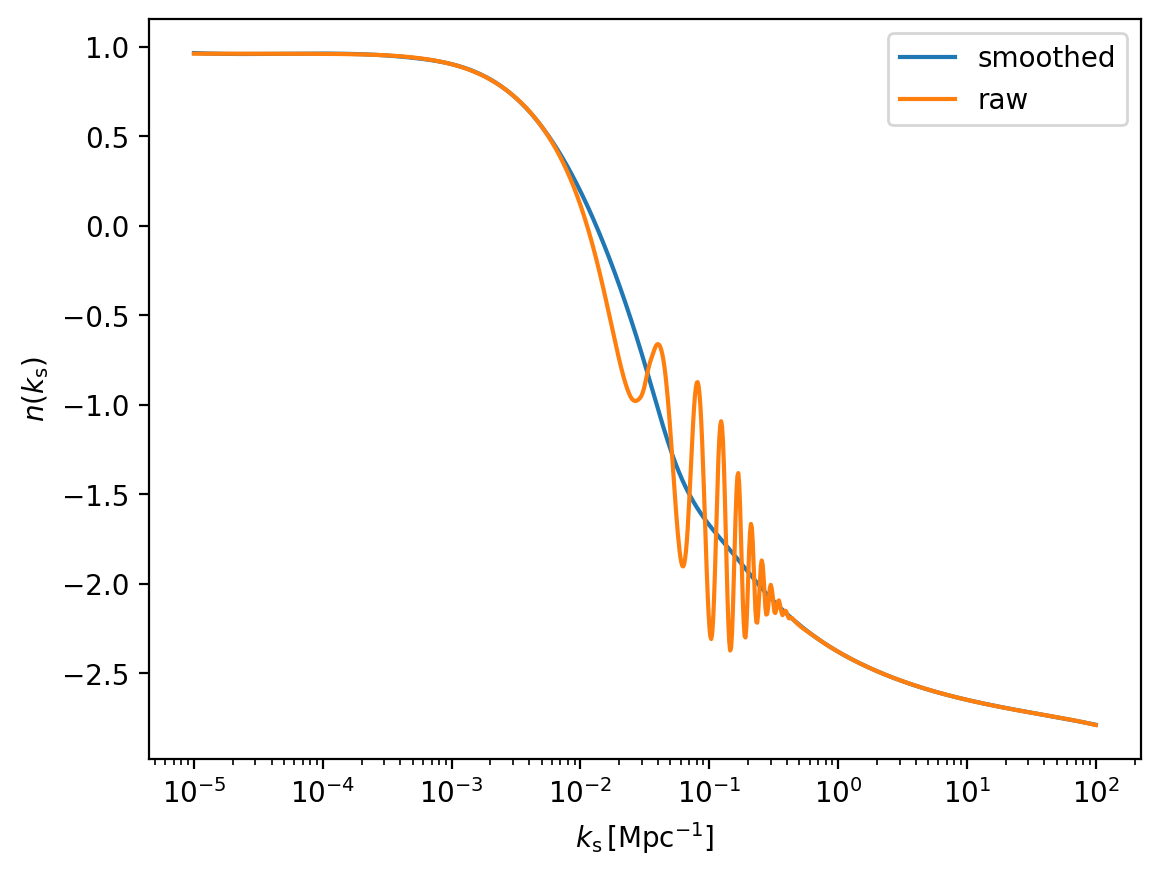

In [2]:
import integrated_bispectrum

from scipy import interpolate as interp
w=np.ones(integrated_bispectrum.nk.size)
w[integrated_bispectrum.ksneff < 5e-3]=100
w[integrated_bispectrum.ksneff > 1]=10
nksp =  interp.UnivariateSpline(np.log(integrated_bispectrum.ksneff), integrated_bispectrum.nk, s = 30, w = w)

plt.semilogx(integrated_bispectrum.ksneff, nksp(np.log(integrated_bispectrum.ksneff)), label = "smoothed")
plt.semilogx(integrated_bispectrum.ksneff, integrated_bispectrum.nk, label = "raw")
plt.xlabel(r"$k_{\rm s} \, [\rm Mpc^{-1}]$")
plt.ylabel(r"$n(k_{\rm s})$")
plt.legend()
plt.savefig("figures/smoothed_nk.pdf", bbox_inches = "tight", dpi = 300)
plt.show()

## Checking bispectrum

In [3]:
import integrated_bispectrum
import scipy.integrate as sinteg

@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, angle12, angle13, angle23, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, angle12, angle13, angle23, integrated_bispectrum.zofchi(chi), model = model)
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 1e-12, integrated_bispectrum.chistar, maxiter = 100, miniter = 50, rtol = 1e-12)[0]

In [4]:
ls = np.arange(2, 4000, 1).astype(np.float64)

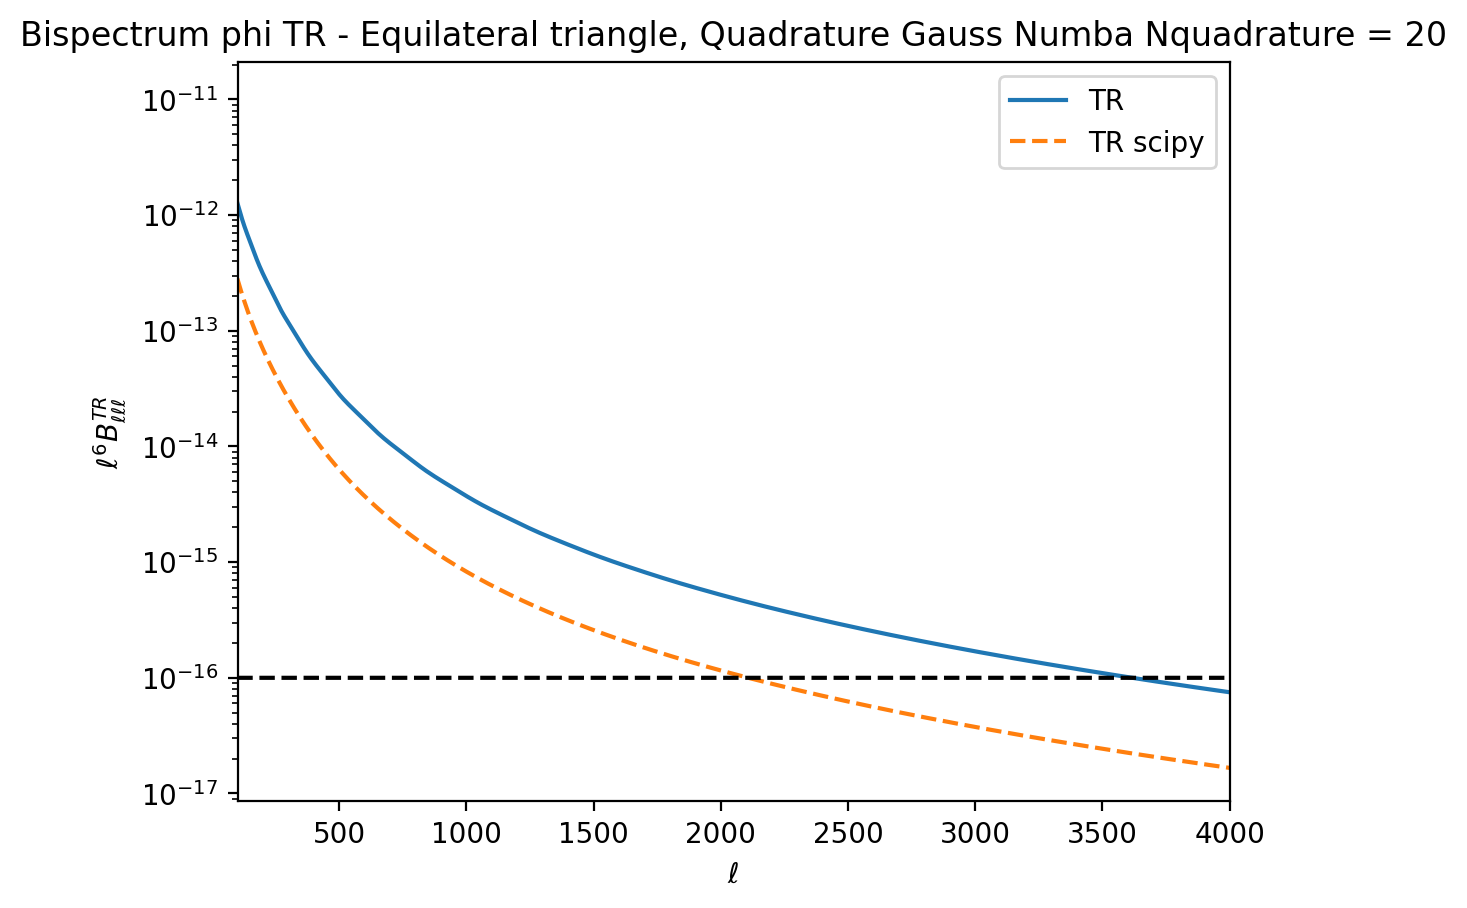

In [5]:
plt.title(f"Bispectrum phi TR - Equilateral triangle, Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
#for N in [10, 20, 30, 40]:
#    plt.plot(ls, ls**6*b3n.bispec_check_quadrature(ls, ls, ls, N), label = f"Quadrature Gauss Numba Nquadrature = {N}")
#plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls, ls), label = f"TR")
#plt.plot(ls, ls**6*b3n.bispec_phi_GM(ls, ls, ls), label = f"GM")

models = ['TR']#, 'SC', 'GM']
for i, model in enumerate(models):
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, ls**6*b3n.bispec_phi_general(ls, ls, ls, i), label = f"{model}")
    plt.plot(ls, calculated*ls**6, label = model+" scipy", ls = '--')

plt.plot(ls, np.zeros_like(ls)+1e-16, color = 'black', ls = '--')

plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()
plt.savefig("figures/bispectrum_phi_TR_equilateral_triangle.png", dpi = 300)

In [6]:
calculated

array([3.84252491e-14, 3.24655423e-15, 5.72909825e-16, ...,
       4.09170069e-39, 4.08262677e-39, 4.07357515e-39])

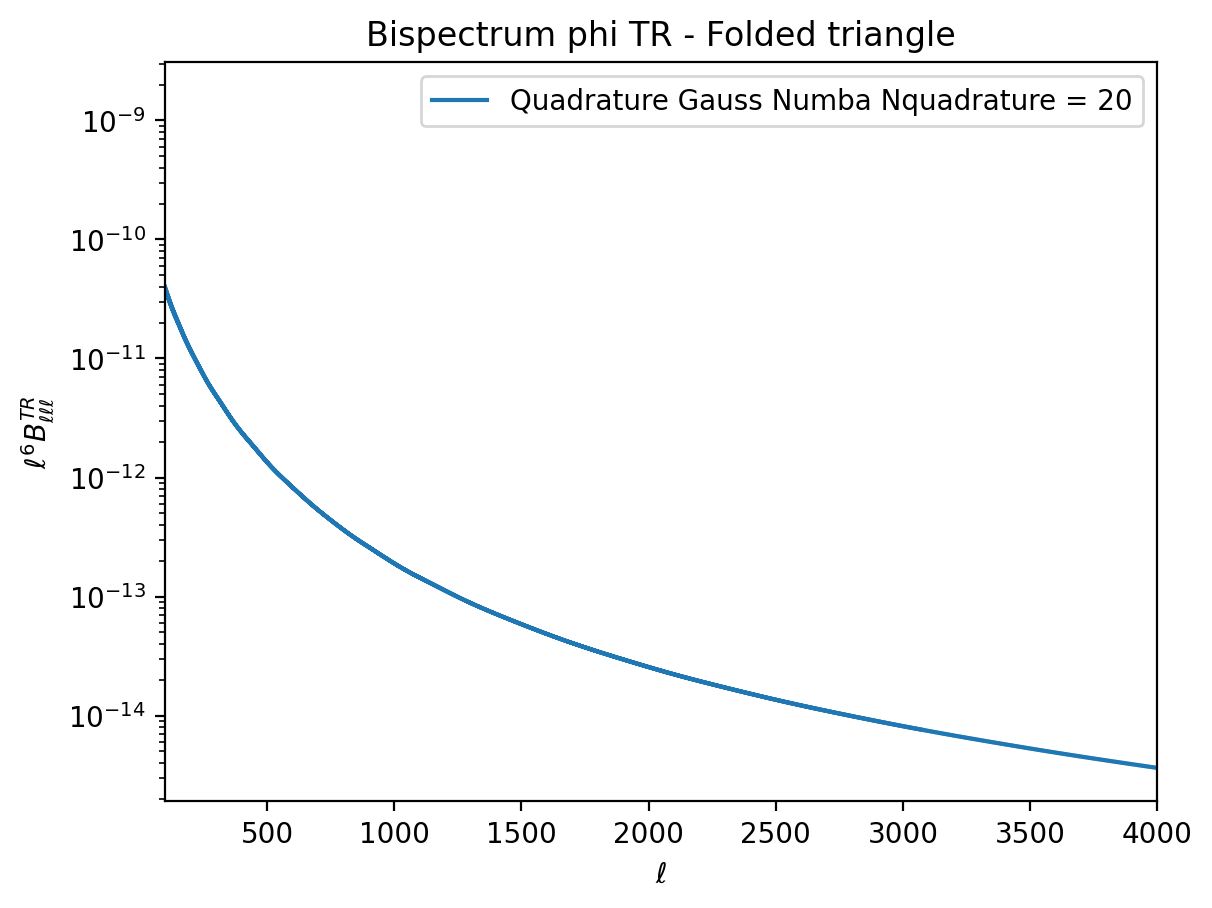

In [7]:
plt.title("Bispectrum phi TR - Folded triangle")
plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls//2, ls//2), label = f"Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()
plt.savefig("figures/bispectrum_phi_TR_folded_triangle.png", dpi = 300)


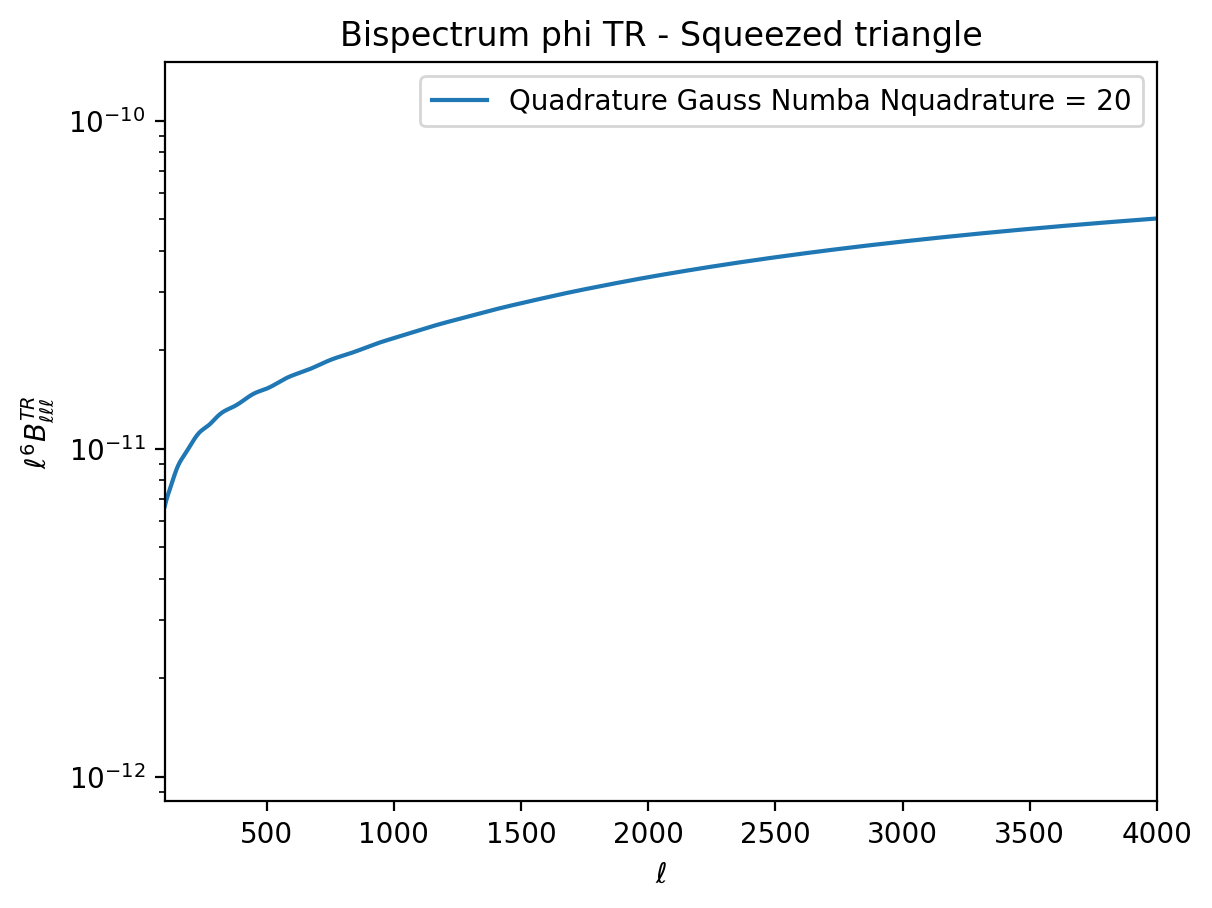

In [8]:
plt.title("Bispectrum phi TR - Squeezed triangle")
ls0 = 50
plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls0, ls, ls), label = f"Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()
plt.savefig("figures/bispectrum_phi_TR_squeezed_triangle.png", dpi = 300)

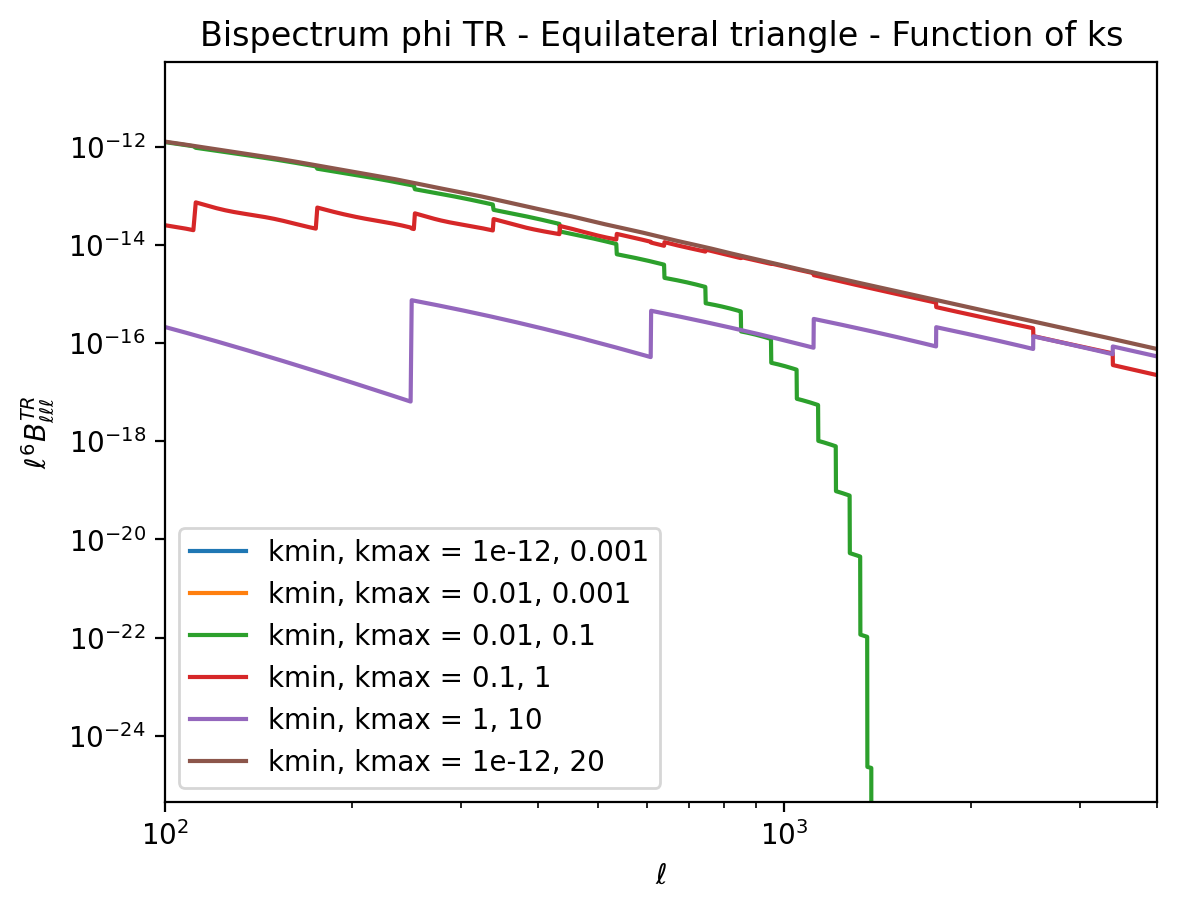

In [9]:
@np.vectorize
def bispec_phi_TR_non_vec_for_k(l1, l2, l3, kmin, kmax):
    return b3n.bispec_phi_TR_non_vec_for_k(l1, l2, l3, kmin, kmax)

plt.title("Bispectrum phi TR - Equilateral triangle - Function of ks")
kmin, kmax = 1, 100
for kmin, kmax in zip([1e-12, 1e-2, 1e-2, 1e-1, 1, 1e-12], [1e-3, 1e-3, 1e-1, 1, 10, 20]):
    plt.plot(ls, ls**6*bispec_phi_TR_non_vec_for_k(ls, ls, ls, kmin, kmax), label = f"kmin, kmax = {kmin}, {kmax}")
plt.yscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(100, 4000)
plt.xscale("log")
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()
plt.savefig("figures/bispectrum_phi_TR_equilateral_triangle_function_of_ks.png", dpi = 300)

## Check CMB experiment

In [10]:
import scipy as sp

In [11]:
lmin, lmax = 10, 4000
print("lmin, lmax", lmin, lmax)
noise, beam = 1., 1.
uTT, lTT, tTT, gTT = ti.get_interpolated(lmin, lmax)

lmin, lmax 10 4000


In [12]:
def dot(a, b):
    return np.dot(a, b)

def fTT(l1v, l2v, l1n, l2n):
    return dot(l1v+l2v, l1v)*lTT(l1n)+dot(l1v+l2v, l2v)*lTT(l2n)

def ftotTT(l):
    return tTT(l)

@numba.jit
def filters(ells):
    return (ells>=lmin) & (ells<=lmax)

def gTT(lv, Lv, lvnorm):
    l1v, l2v = lv, Lv-lv
    l1n, l2n = lvnorm, np.linalg.norm(l2v, axis = 0)
    return fTT(l1v, l2v, l1n, l2n)/(2*ftotTT(l1n)*ftotTT(l2n))#*filters(l1n)*filters(l2n)

In [13]:
from interpolation import interp

@numba.jit(nopython = True)
def uTTinterp(l):
    return interp(ti.L, ti.unlensed, l) 

@numba.jit(nopython = True)
def lTTinterp(l):
    return interp(ti.L, ti.lensed, l) 

@numba.jit(nopython = True)
def gTTinterp(l):
    return interp(ti.L, ti.gradTT, l) 

noise_component = ti.get_noise(ti.L, noise, beam)
@numba.jit(nopython = True)
def tTTinterp(l):
    return interp(ti.L, ti.lensed+noise_component, l) 

#lTT = sp.interpolate.interp1d(ti.L, ti.lensed, fill_value = 0., bounds_error = False)
#tTT = sp.interpolate.interp1d(ti.L, ti.lensed+ti.get_noise(L, noise, beam), fill_value = 1e10, bounds_error = False)

In [147]:
m

In [148]:
Nquadrature = 200
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

In [149]:
Nquadrature = 30
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)
AA, AAgrad = get_integral_for_AL(10, lmin, lmax, l2res = 10, xgauss = l2gauss, wgauss = w2gauss)
Nquadrature = 500
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)
BB, BBgrad = get_integral_for_AL(10, lmin, lmax, l2res = 10, xgauss = l2gauss, wgauss = w2gauss)
print(AA/BB-1)
print(AAgrad/BBgrad-1)
print(AA/AAgrad-1)

-0.018836984888602748
-0.019947673730510762
0.1006238829414261


In [150]:
Ls = np.linspace(20, 4000, 40)

In [151]:
Nquadrature = 500
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

In [152]:
Amatrix = np.array([get_integral_for_AL(LL, lmin, lmax, l2res = 2000, xgauss = l2gauss, wgauss = w2gauss) for LL in Ls])
ALsanall, ALsanal = Amatrix.T

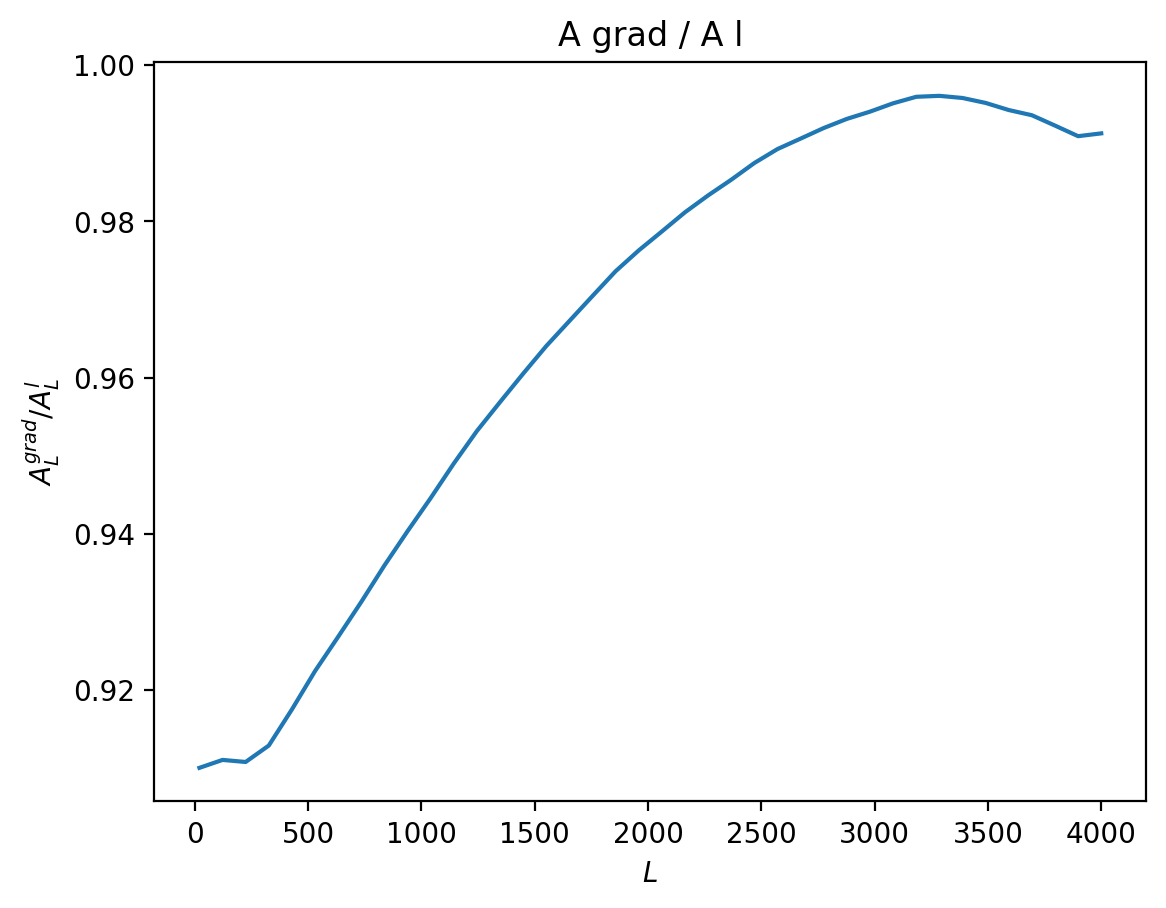

In [153]:
plt.title("A grad / A l")
plt.plot(Ls, ALsanal/ALsanall)
plt.xlabel(r"$L$") 
plt.ylabel(r"$A_{L}^{grad}/A_{L}^{l}$")
plt.savefig("figures/ALgradALl.pdf", dpi = 300)

In [154]:
l, potential = np.loadtxt('/Users/omard/Downloads/potential_from_camb_demuni.txt', unpack = True)
ppinterp = np.interp(Ls, l, potential)

### Getting $N^{3/2}$ analytical

In [155]:
@numba.jit(nopython = True, fastmath = True, parallel = True)
def get_integral_for_L(L, lmin, lmax, l1res = 10, l2res = 10, theta1par = 512, theta2par = 512,
                       l1gauss = None, w1gauss = None, l2gauss = None, w2gauss = None,
                       thet1gauss = None, wthet1gauss = None, thet2gauss = None, wthet2gauss = None, index = 0):

    eps = 1e-4
    epsilonl = 1e-6

    integralL = 0.

    l1s = np.linspace(lmin, lmax, l1res) if l1gauss is None else l1gauss
    dl1 = np.float(lmax-lmin)/np.float(l1res)

    l2s = np.linspace(lmin, lmax, l2res) if l2gauss is None else l2gauss

    dl2 = np.float(lmax-lmin)/np.float(l2res)

    N1s = l1s.shape[0]
    N2s = l2s.shape[0]

    integral1 = np.empty(N1s, dtype = np.float64)

    for i in numba.prange(N1s):
        
        l1 = l1s[i]

        ntheta1 =  max(32, 2*int(l1)+1) 
        ntheta1 = min(ntheta1, theta1par) 
        dtheta1 = (2*np.pi/ntheta1)
        theta1s = np.linspace(eps, 2*np.pi-eps, ntheta1) if thet1gauss is None else thet1gauss
        
        integraltheta1 = np.empty(theta1s.shape, dtype = np.float64)
    
        for it1 in range(ntheta1):
            theta1 = theta1s[it1]

            cos1 = np.cos(theta1)
            sin1 = np.sin(theta1)
            l3 = np.sqrt(L**2+l1**2-2*L*l1*cos1)+epsilonl
    
            #weight1 = dtheta1*l1/(2*np.pi)**2
            weight1 = l1/(2*np.pi)**2
    
            bispectrum_term = b3n.bispec_phi_general_non_vec(l1, l3, L, index)

            integral2 = np.empty(l2s.shape, dtype = np.float64)
            
            for i2 in numba.prange(N2s):
                
                l2 = l2s[i2]

                ntheta2 =  max(32,2*int(l2)+1) 
                ntheta2 = min(ntheta2, theta2par) 
                dtheta2 = (2*np.pi/ntheta2)
                theta2s = np.linspace(eps, 2*np.pi-eps, ntheta2) if (thet2gauss is None) else thet2gauss
                
                Cl2 = gTTinterp(l2) #uTTinterp(l2)
            
                cos2s = np.cos(theta2s)
                sin2s = np.sin(theta2s)

                #weight2 = dtheta2*l2/(2*np.pi)**2*dl2
                weight2 = l2/(2*np.pi)**2

                l4 = np.sqrt(L**2+l2**2 -2*L*l2*cos2s)+epsilonl
                l5 = np.sqrt((l1*cos1-l2*cos2s)**2+(l1*sin1-l2*sin2s)**2)+epsilonl

                Cl5 = gTTinterp(l5) #uTTinterp(l5)
                
                #Cl5[l5 > lmax] = 0
                #Cl5[l5 < lmin] = 0

                #gTT = np.empty(theta2s.shape, dtype = np.float64)
                #gTT[(l4<lmin) & (l4>lmax)] = 0
                #selection = (l4>lmin) & (l4<lmax)
                
                l4_dot_L = (-L*l2*cos2s + L**2)
                l2_dot_L = (L*l2*cos2s)

                response = (l4_dot_L*gTTinterp(l4) + l2_dot_L*gTTinterp(l2)) 
                filter = 1/(2*tTTinterp(l2)*tTTinterp(l4))
                #gTT[selection] = response*filter
                
                filter[l4<lmin] = 0
                filter[l4>lmax] = 0 
                gTT = response*filter

                l1_dot_l2 = (l1*cos1*l2*cos2s) + (l1*sin1*l2*sin2s)
                l2_dot_l3 = l2_dot_L-l1_dot_l2
                l5_dot_l1 = l1**2-l1_dot_l2
                l5_dot_l3 = L*l1*cos1-l2_dot_L-l1**2+l1_dot_l2

                A1terms = -l5_dot_l1*l5_dot_l3*1*1*Cl5*gTT
                C1terms = l2_dot_l3*l1_dot_l2*1*1*Cl2*gTT*2*1/2

                somma = np.trapz(A1terms+C1terms, theta2s)*weight2 if wthet2gauss is None else np.dot(A1terms+C1terms, wthet2gauss)*weight2

                integral2[i2] = somma

            integral2 = np.trapz(integral2, l2s) if w2gauss is None else np.dot(integral2, w2gauss)
            integral2 *= bispectrum_term
            integraltheta1[it1] = integral2
            integral1[i] = np.trapz(integraltheta1, theta1s) if wthet1gauss is None else np.dot(integraltheta1, wthet1gauss)*weight1
            #weight1*integral2*bispectrum_term
            #integral2*bispectrum_term
    integralL = np.trapz(integral1, l1s) if w1gauss is None else np.dot(integral1, w1gauss)
    return integralL

            
            
        


In [156]:
@numba.jit(nopython = True, fastmath = True)
def get_integral_for_L_external(L, lmin, lmax, theta2par = 512, l2gauss = None, w2gauss = None):

    eps = 1e-4
    epsilonl = 1e-6

    l2s = l2gauss

    l1, cos1, sin1 = 100, 1, 0

    N2s = l2s.shape[0]

    integral2 = np.empty(l2s.shape, dtype = np.float64)

            
    for i2 in numba.prange(N2s):
    
        l2 = l2s[i2]

        ntheta2 =  max(32,2*int(l2)+1) 
        ntheta2 = min(ntheta2, theta2par) 
        dtheta2 = (2*np.pi/ntheta2)
        theta2s = np.linspace(eps, 2*np.pi-eps, ntheta2) 

        Cl2 = gTTinterp(l2) #uTTinterp(l2)
        
        cos2s = np.cos(theta2s)
        sin2s = np.sin(theta2s)

        #weight2 = dtheta2*l2/(2*np.pi)**2*dl2
        weight2 = l2/(2*np.pi)**2

        l4 = np.sqrt(L**2+l2**2 -2*L*l2*cos2s)+epsilonl
        l5 = np.sqrt((l1*cos1-l2*cos2s)**2+(l1*sin1-l2*sin2s)**2)+epsilonl

        Cl5 = gTTinterp(l5) #uTTinterp(l5)
        
        Cl5[l5 > lmax] = 0
        Cl5[l5 < lmin] = 0

        #gTT = np.empty(theta2s.shape, dtype = np.float64)
        #gTT[(l4<lmin) & (l4>lmax)] = 0
        #selection = (l4>lmin) & (l4<lmax)
        
        l4_dot_L = (-L*l2*cos2s + L**2)
        l2_dot_L = (L*l2*cos2s)

        response = (l4_dot_L*gTTinterp(l4) + l2_dot_L*gTTinterp(l2)) 
        filter = 1/(2*tTTinterp(l2)*tTTinterp(l4))
        #gTT[selection] = response*filter
        
        filter[l4<lmin] = 0
        filter[l4>lmax] = 0 
        gTT = response*filter

        l1_dot_l2 = (l1*cos1*l2*cos2s) + (l1*sin1*l2*sin2s)
        l2_dot_l3 = l2_dot_L-l1_dot_l2
        l5_dot_l1 = l1**2-l1_dot_l2
        l5_dot_l3 = L*l1*cos1-l2_dot_L-l1**2+l1_dot_l2

        A1terms = -l5_dot_l1*l5_dot_l3*1*1*Cl5*gTT
        C1terms = l2_dot_l3*l1_dot_l2*1*1*Cl2*gTT*2*1/2

        somma = np.trapz(A1terms+C1terms, theta2s)*weight2

        integral2[i2] = somma


    return np.dot(integral2, w2gauss)

            
            
        


In [157]:
Nquadrature = 150
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

#vals = np.array([get_integral_for_L_external(L, lmin, lmax, theta2par = 4096, l2gauss=l2gauss, w2gauss=w2gauss) for L in Ls])

Lss = np.linspace(2, 3500, 50)
vals2 = np.array([get_integral_for_L_external(L, lmin, lmax, theta2par = 64, l2gauss = l2gauss, w2gauss = w2gauss) for L in Lss])

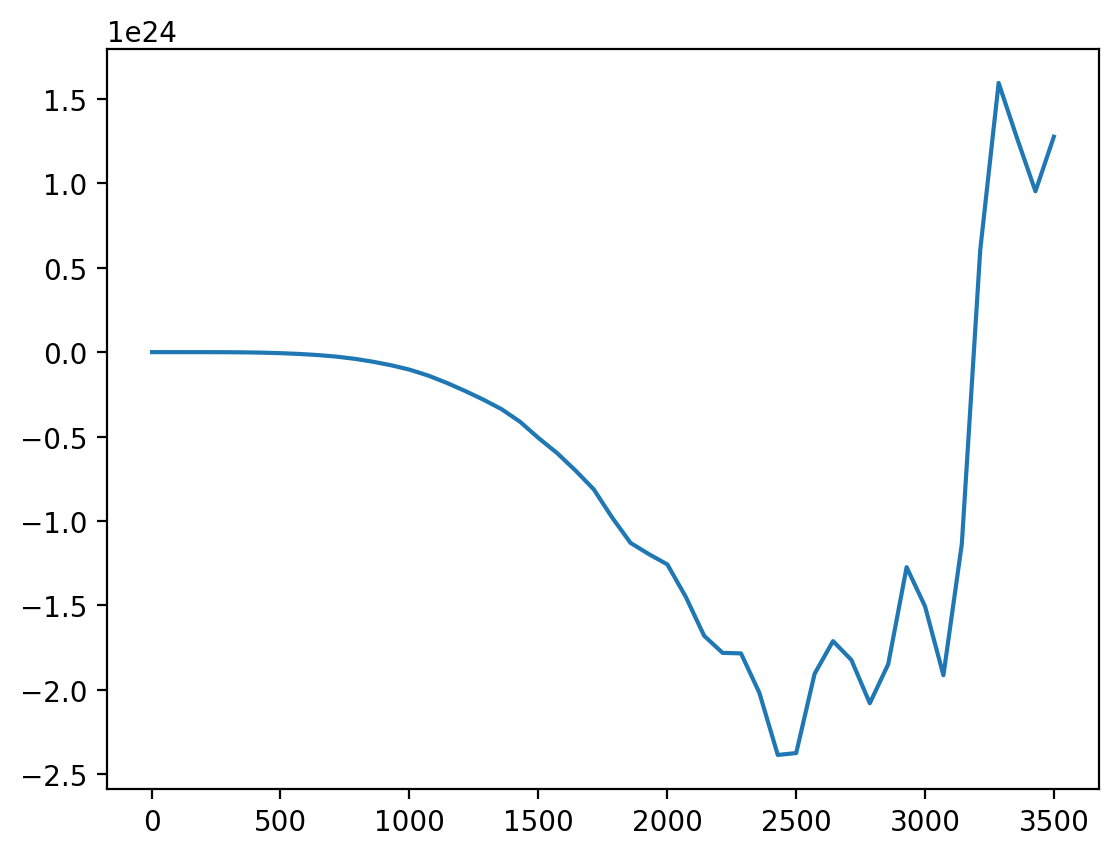

In [158]:
plt.plot(Lss, vals2)

In [159]:
get_integral_for_L(3000, lmin, lmax, l1res = 10, l2res = 10, index = 1)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


-0.00012243771148889483

In [160]:
get_integral_for_L(3000, lmin, lmax, l1res = 10, l2res = 10, index = 1)

-0.00012243771148889483

In [161]:
get_integral_for_L(3000, lmin, lmax, l1res = 100, l2res = 100)

In [ ]:
index = 2

In [ ]:
Nquadrature = 15
l1gauss, w1gauss = gaussxw(lmin, lmax, Nquadrature)

Nquadrature = 50
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

AA = get_integral_for_L(1020, lmin, lmax, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 128, theta2par = 128, index = index)


Nquadrature = 100
l1gauss, w1gauss = gaussxw(lmin, lmax, Nquadrature)

Nquadrature = 100
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

BB = get_integral_for_L(1020, lmin, lmax, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 128, theta2par = 256, index = index)

print(AA/BB-1)

-0.0008124661601948135


In [ ]:
get_integral_for_L(1020, lmin, lmax, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 64, theta2par = 128, index = index)

-0.0006447087117691897

In [ ]:
Nquadrature = 50
l1gauss, w1gauss = gaussxw(lmin, lmax, Nquadrature)

Nquadrature = 100
l2gauss, w2gauss = gaussxw(lmin, lmax, Nquadrature)

get_integral_for_L(1020, lmin, lmax, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 64, theta2par = 128, index = index)

-0.0006480818367045136

In [ ]:
get_integral_for_L(1020, lmin, lmax, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 64, theta2par = 64)/get_integral_for_L(1020, lmin, lmax, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 64, theta2par = 128)-1

-0.01647902870413709

In [ ]:
print("lmin, lmax", lmin, lmax)
result_analytical = np.array([get_integral_for_L(LL, lmin, lmax, l1gauss = l1gauss, w1gauss = w1gauss, l2gauss = l2gauss, w2gauss = w2gauss, theta1par = 64, theta2par = 128, index = index) for LL in Lss])

lmin, lmax 10 4000


In [ ]:
Amatrix = np.array([get_integral_for_AL(LL, lmin, lmax, l2res = 2000, xgauss = l2gauss, wgauss = w2gauss) for LL in Lss])
ALsanall, ALsanal = Amatrix.T

In [ ]:
ppinterp = np.interp(Lss, l, potential)

In [ ]:
plt.loglog(Lss, abs(np.array(result_analytical)*ALsanal**-1), label = "N32 bias")
plt.loglog(Lss, ppinterp, label = "Potential")
plt.loglog(Lss, ALsanal**-1, label = "Normalization")
plt.legend()

NameError: name 'Lss' is not defined

In [ ]:
#TRlevelanal =  (result_analytical)*ALsanal**-1./ppinterp
#SClevelanal =  (result_analytical)*ALsanal**-1./ppinterp
#GMlevelanal =  (result_analytical)*ALsanal**-1./ppinterp

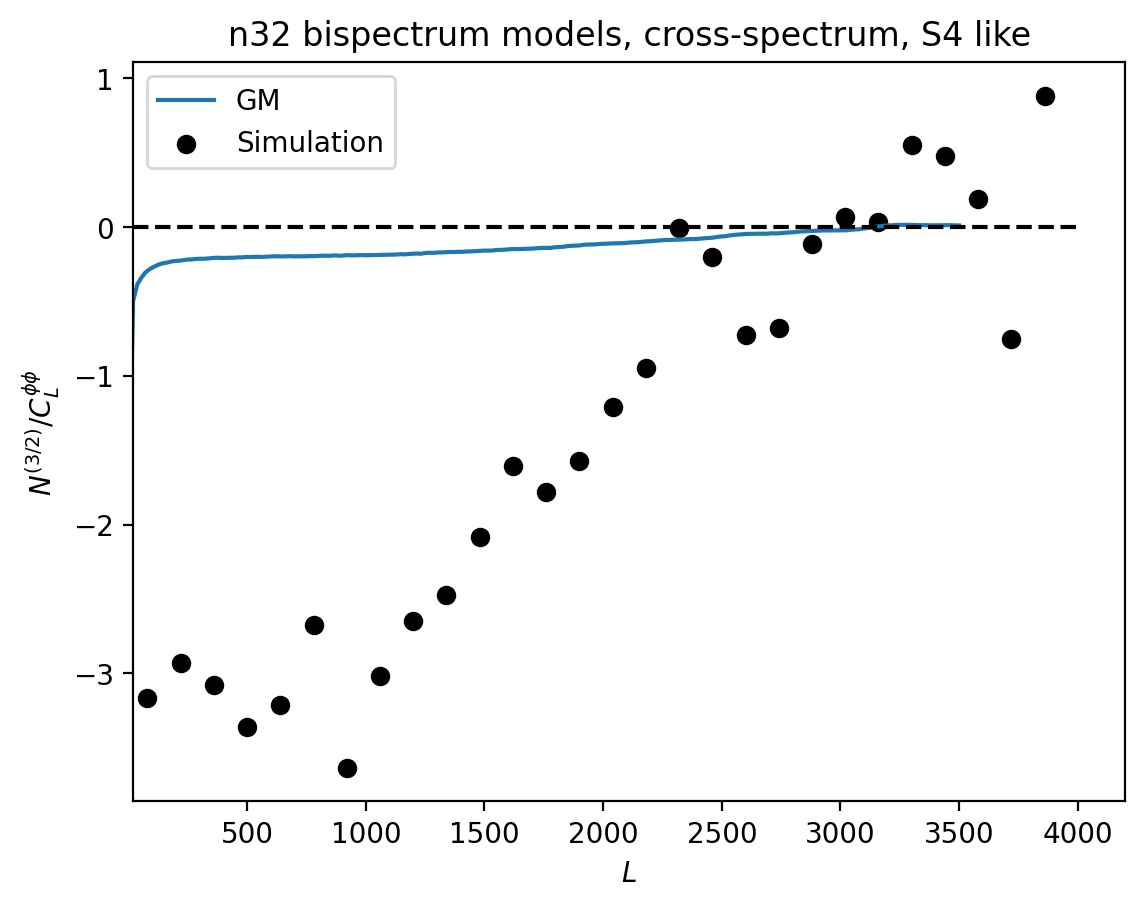

In [ ]:
ppinterp = np.interp(Lss, ti.l, ti.pp)
plt.title("n32 bispectrum models, cross-spectrum, S4 like")
plt.plot(Lss, (result_analytical)*ALsanal**-1./ppinterp*100, label = "GM")
#plt.plot(Lss, GMlevelanal*100, label = "GM")
#plt.plot(Lss, TRlevelanal*100, label = "TR")
#plt.plot(Lss, SClevelanal*100, label = "SC")

datafromsims = np.loadtxt("cross_n32_.txt")
elsims, n32qe = datafromsims[:, 0], datafromsims[:, 1]
plt.scatter(elsims, n32qe*100, label = 'Simulation', color = 'k')
plt.plot(Ls, Ls*0., "k--")
plt.xlim(20)
plt.xlabel("$L$")
plt.ylabel("$N^{(3/2)}/C_L^{\phi\phi}$")
#plt.ylim(-0.5, 0.1)
plt.legend()

## Use Vegas for the integration

In [14]:
lmin, lmax = 10, 4000
print("lmin, lmax", lmin, lmax)
noise, beam = 1., 1.
uTT, lTT, tTT, gTT = ti.get_interpolated(lmin, lmax, noise, beam)

lmin, lmax 10 4000


In [504]:
lmin, lmax = 10, 4000
print("lmin, lmax", lmin, lmax)
noise, beam = 1., 1.*np.sqrt(2)
uEE, lEE, tEE, gEE = ti.get_interpolatedEE(lmin, lmax, noise, beam)

lmin, lmax 10 4000


In [505]:
lBB, gBB, tBB = ti.get_interpolatedBB(lmin, lmax, noise, beam)

In [506]:
import vegas

In [507]:
def dotbatch(a, b):
    return a[0, :]*b[0, :]+a[1, :]*b[1, :]


def funlTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*uTT(l1n)+dotbatch(Lv, l2v)*uTT(l2n)

def flenTTbatch(l1v, l2v, l1n, l2n):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*lTT(l1n)+dotbatch(Lv, l2v)*lTT(l2n)

def fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT):
    Lv = l1v+l2v
    return dotbatch(Lv, l1v)*gradientTT(l1n)+dotbatch(Lv, l2v)*gradientTT(l2n)

def ftotTTfTTbatchbase(l):
    return tTT(l)

def ftotEEfEEbatch(l):
    return tEE(l)

def ftotBBfBBbatch(l):
    return tBB(l)

def gfTTbatch(lv, Lv, l1n, l2n, gradientTT):
    l1v, l2v = lv, Lv-lv
    return fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

def gfTTbatch_for_modes(l1v, l2v, l1n, l2n, gradientTT, ftotTTfTTbatch = ftotTTfTTbatchbase):
    return fgradTTbatch(l1v, l2v, l1n, l2n, gradientTT)/(2*ftotTTfTTbatch(l1n)*ftotTTfTTbatch(l2n))

In [508]:
from interpolation import interp

@numba.jit(nopython = True)
def uTTinterp(l):
    return interp(ti.L, ti.unlensed, l) 

@numba.jit(nopython = True)
def lTTinterp(l):
    return interp(ti.L, ti.lensed, l) 

@numba.jit(nopython = True)
def gTTinterp(l):
    return interp(ti.L, ti.gradTT, l) 

noise_component = ti.get_noise(ti.L, noise, beam)
@numba.jit(nopython = True)
def tTTinterp(l):
    return interp(ti.L, ti.lensed+noise_component, l) 

#lTT = sp.interpolate.interp1d(ti.L, ti.lensed, fill_value = 0., bounds_error = False)
#tTT = sp.interpolate.interp1d(ti.L, ti.lensed+ti.get_noise(L, noise, beam), fill_value = 1e10, bounds_error = False)

### Get normalization to check the vegas code

In [663]:
#Ls = Lss
Ls = np.arange(10, 3500, 200)
len(Ls)

18

In [664]:
filter_batch = lambda x: (x >= lmin) & (x <= lmax)

In [778]:

noise_component = ti.get_noise(ti.L, noise, beam)
@numba.jit(nopython = True)
def tTTinterp(l):
    return interp(ti.L, ti.lensed+noise_component, l) 



def get_AL_MC(Ls, gradientTT, gradientEE, gradientBB, totalTT = ftotTTfTTbatchbase):
    integ = vegas.Integrator([[lmin, lmax], [0, 2*np.pi]])
    nitn, neval = 1e3, 1e3

    ALMC = []

    for LL in Ls:
        @vegas.batchintegrand
        def integrand(x):
            l1, theta1 = x.T
            l1v = np.array([l1*np.cos(theta1), l1*np.sin(theta1)])
            L = np.ones_like(l1)*LL
            Lv = np.c_[L, np.zeros_like(l1)].T
            l3v = Lv-l1v

            l3 = np.linalg.norm(l3v, axis = 0)

            fXY = fgradTTbatch(l1v, l3v, l1, l3, gradientTT)
            #fXY = fgradEBbatch(l1v, l3v, l1, l3, gradientEE, gradientBB)

            gXY = gfTTbatch_for_modes(l1v, l3v, l1, l3, gradientTT, totalTT)*filter_batch(l3)
            #gXY = gfEBbatch(l1v, Lv, l1, l3, gradientEE, gradientBB)*filter_batch(l3)
            #cos = np.cos(theta1)
            #fXY =((-L*l1*cos + L**2)*gradientTT(l3) + (L*l1*cos)*gradientTT(l1))
            #gXY = fXY/(2*tTTinterp(l1)*tTTinterp(l3))*filter_batch(l3)

            product = fXY*gXY     
            common = l1/(2*np.pi)**2

            return product*common
        
        result = integ(integrand, nitn = nitn, neval = neval)
        ALMC += [result.mean]

    ALMC = np.array(ALMC)**-1.

    return ALMC



In [779]:
class C(object):

    def __init__(self):
        self.a = None
    def __call__(self):
        return 1.
    
    def execute(self):
        for self.a in [1, 2, 3]:
            print(self.a)
        return self()
    
A = C()
A()
A.execute()

1
2
3


1.0

In [780]:

gradientTT, gradientEE, gradientBB = gTT, gEE, gBB
ALMC = get_AL_MC(Ls, gradientTT, _, _)


In [781]:
ppinterp = np.interp(Ls, ti.l, ti.pp)

In [782]:
Lsg, respg = np.loadtxt("respgiu.txt", unpack = True)

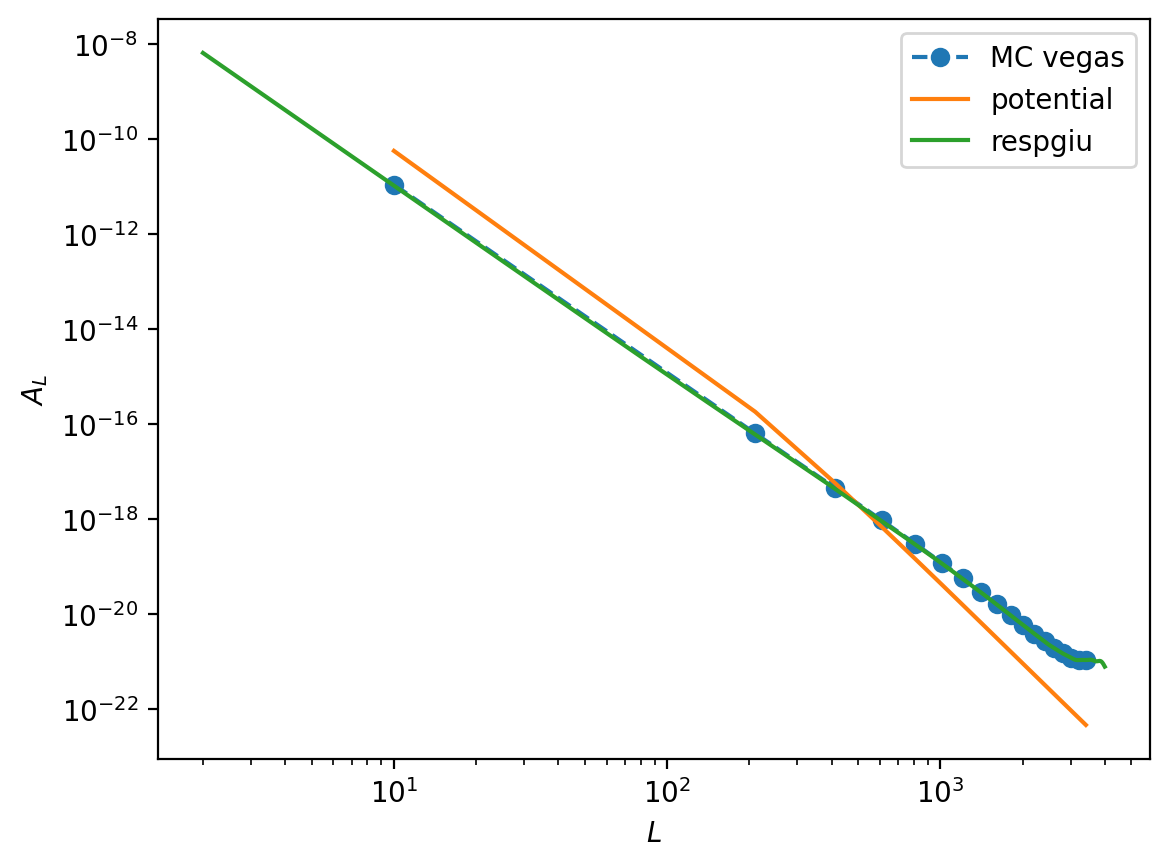

In [783]:
#plt.loglog(cents, Alphi, label = "symlens")

plt.loglog(Ls, ALMC, ls = "--", marker = 'o', label = "MC vegas")

plt.loglog(Ls, ppinterp, label = "potential")
#plt.loglog(cents, Alphi)
#plt.loglog(Lss, ALsanal**-1., label = "analytical")

plt.plot(Lsg, respg**-1*2, label = "respgiu")

#plt.loglog(Ls, np.array([get_integral_for_AL(LL, lmin, lmax, l2res = res, xgauss = l2gauss, wgauss = w2gauss) for LL in Ls])**-1., ls = '--', label = f"res = Gauss")
plt.legend()

plt.xlabel(r"$L$")
plt.ylabel(r"$A_L$")

plt.savefig("figures/ALcomparisons.png", dpi = 300)

### Now get the $N^{(3/2)}$ bias

In [784]:
integ = vegas.Integrator([[lmin, lmax], [lmin, lmax], [0, 2*np.pi], [0, 2*np.pi]], nhcube_batch = 2000)

In [785]:
comb = "tt"
casi = np.load(f"casi_{comb}_empirical.npy", allow_pickle = True).item()
gradientTTs = []
for ii in range(3):
    gradTT_it = casi[ii]
    ellgrad = np.arange(2, len(gradTT_it)+2)
    gTT_it = sp.interpolate.interp1d(ellgrad, gradTT_it[:,0], fill_value = 0., bounds_error = False)
    gradientTTs += [gTT_it]

lws, Ws0 = np.loadtxt("W0.txt", unpack = True)
lws, Ws1 = np.loadtxt("W1.txt", unpack = True)
lws, Ws2 = np.loadtxt("W2.txt", unpack = True)

Wss = list(map(lambda x: sp.interpolate.interp1d(lws, np.nan_to_num(x), fill_value = 0., bounds_error = False), [Ws0, Ws1, Ws2]))


In [786]:
from scipy import signal
import scipy

def bin_theory(l, lcl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic = 'sum', bins = bin_edges)
    cl = scipy.stats.binned_statistic(l, lcl, statistic = 'sum', bins = bin_edges)
    cl = cl[0]/sums[0]
    return cl

bin_edges = np.arange(1, 4500, 40)

elbin = (bin_edges[:-1]+bin_edges[1:])/2

In [787]:
"""Ws = np.load("norms_gauss_born_gaussian.npy")
lws = np.arange(Ws.shape[1])
Wsinterp = sp.interpolate.interp1d(elbin, bin_theory(lws, lws*Ws[0], bin_edges), fill_value = 0., bounds_error = False)
Wsinterpiter1 = sp.interpolate.interp1d(elbin, bin_theory(lws, lws*Ws[1], bin_edges), fill_value = 0., bounds_error = False)

plt.loglog(lws, Ws[0], label = "iter 0", alpha = 0.4, color = 'blue')
plt.loglog(lws, Wsinterp(lws), color = 'blue')
plt.loglog(lws, Ws[1], label = "iter 1",alpha = 0.4, color = 'red')
plt.loglog(lws, Wsinterpiter1(lws), color = 'red')
plt.legend()"""

"""np.savetxt("W0.txt", np.c_[lws, Ws[0]])
np.savetxt("W1.txt", np.c_[lws, Ws[1]])
np.savetxt("W2.txt", np.c_[lws, Ws[2]])"""

'np.savetxt("W0.txt", np.c_[lws, Ws[0]])\nnp.savetxt("W1.txt", np.c_[lws, Ws[1]])\nnp.savetxt("W2.txt", np.c_[lws, Ws[2]])'

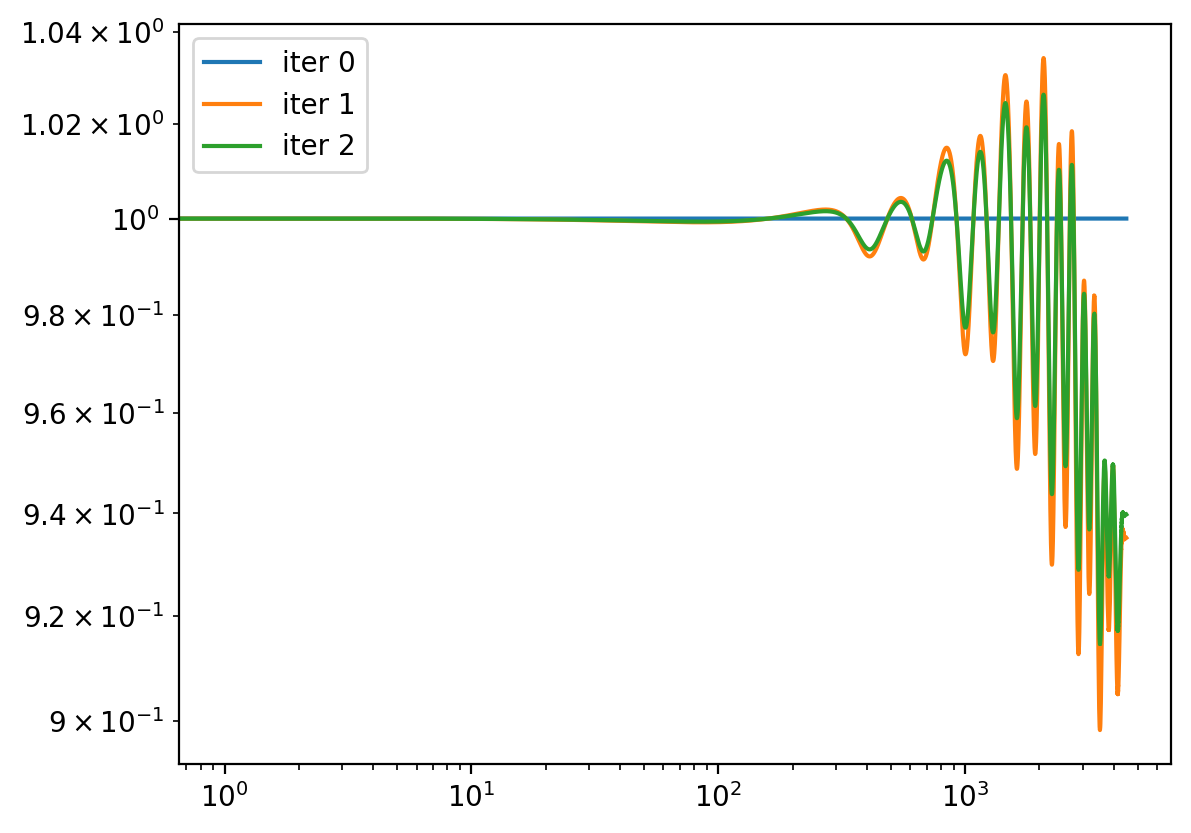

In [788]:
for ii in range(3):

    noise_component = ti.get_noise(ti.L, noise, beam)

    lpartial, ttpartial = np.loadtxt(f"tt_partial_{ii}.txt", unpack = True)
    ttpartial_interp = np.interp(ti.L, lpartial, ttpartial)

    @numba.jit(nopython = True)
    def tTTinterp(l):
        return interp(ti.L, ttpartial_interp+noise_component, l) 
    
    lsprova = np.arange(0, 4500)

    if ii == 0:
        tt0 = tTTinterp(lsprova)

    plt.loglog(lsprova, tTTinterp(lsprova)/tt0, label = "iter %d"%ii)
plt.legend()

In [789]:
from plancklens import qresp
from scipy import interpolate as interpsc

In [790]:
lpartial

array([0.000e+00, 1.000e+00, 2.000e+00, ..., 4.398e+03, 4.399e+03,
       4.400e+03])

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_45753/1869496125.py:18: RuntimeWarning: divide by zero encountered in divide
  fal = {"tt": np.nan_to_num(1/ttpartial_interp_scipy(ls))*mask}


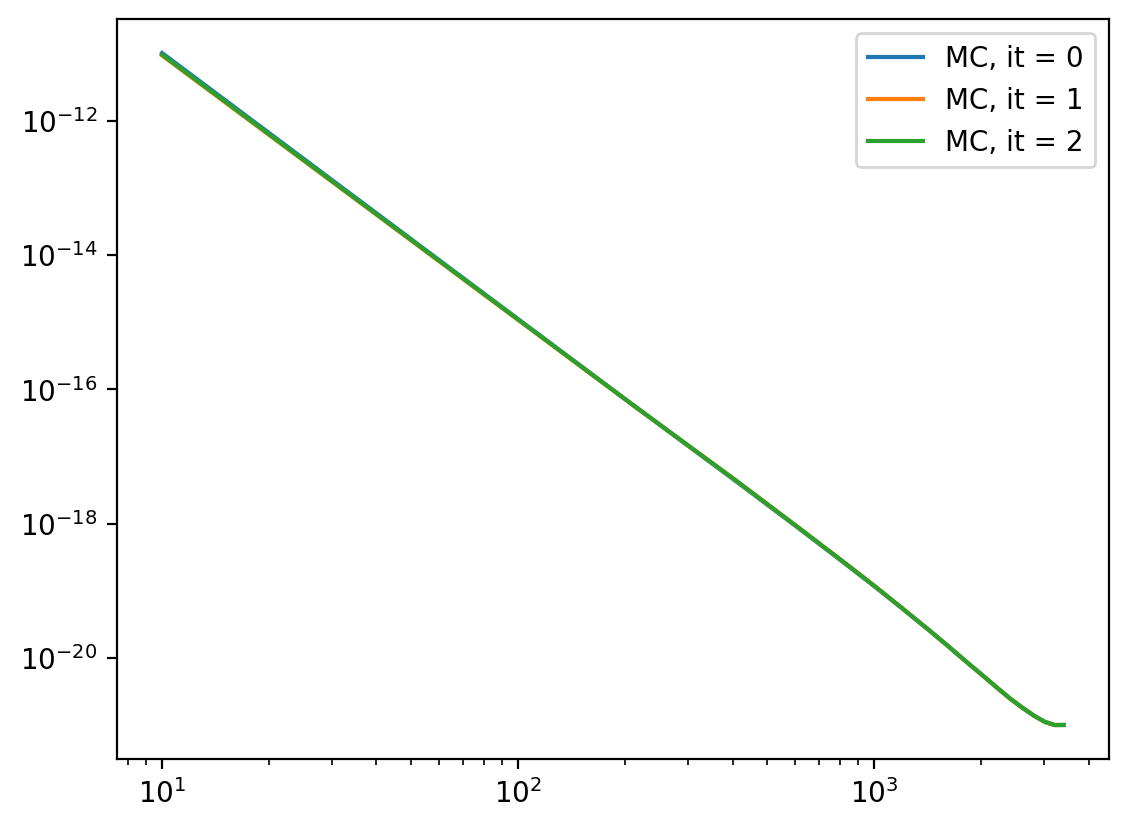

In [800]:
ALMCS = {}
r_ggs = {}
for it in [0, 1, 2]:

    noise_component = ti.get_noise(ti.L, noise, beam)

    lpartial, ttpartial = np.loadtxt(f"tt_partial_{ii}.txt", unpack = True)
    ttpartial_interp =  np.interp(ti.L, lpartial, ttpartial)
    ttpartial_interp_scipy = interpsc.interp1d(lpartial, ttpartial, fill_value="extrapolate", kind = 'cubic')


    #@numba.jit(nopython = True)
    def tTTinterp(l):
        return interp(ti.L, ttpartial_interp+noise_component, l) 
    
    ls = np.arange(0, 4500)
    mask = (ls > lmin) & (ls < lmax)
    fal = {"tt": np.nan_to_num(1/ttpartial_interp_scipy(ls))*mask}

    cls_f = {"tt": gradientTTs[it](ls)*mask}

    cls_w = {"tt": ttpartial_interp_scipy(ls)}

    qe_key = "ptt"
    lmax_ivf = 4499
    r_gg_true = qresp.get_response(qe_key, lmax, 'p', cls_w, cls_f, fal, lmax_qlm = lmax_ivf)[0]
    r_ggs[it] = r_gg_true


    ALMC_ = get_AL_MC(Ls, gradientTTs[it], _, _, tTTinterp)
    if i == 0:
        ALMC = ALMC_
    ALMCS[it] = ALMC_

for it in [0, 1, 2]:
    plt.loglog(Ls, ALMCS[it], label = "MC, it = %d"%it)
plt.legend()

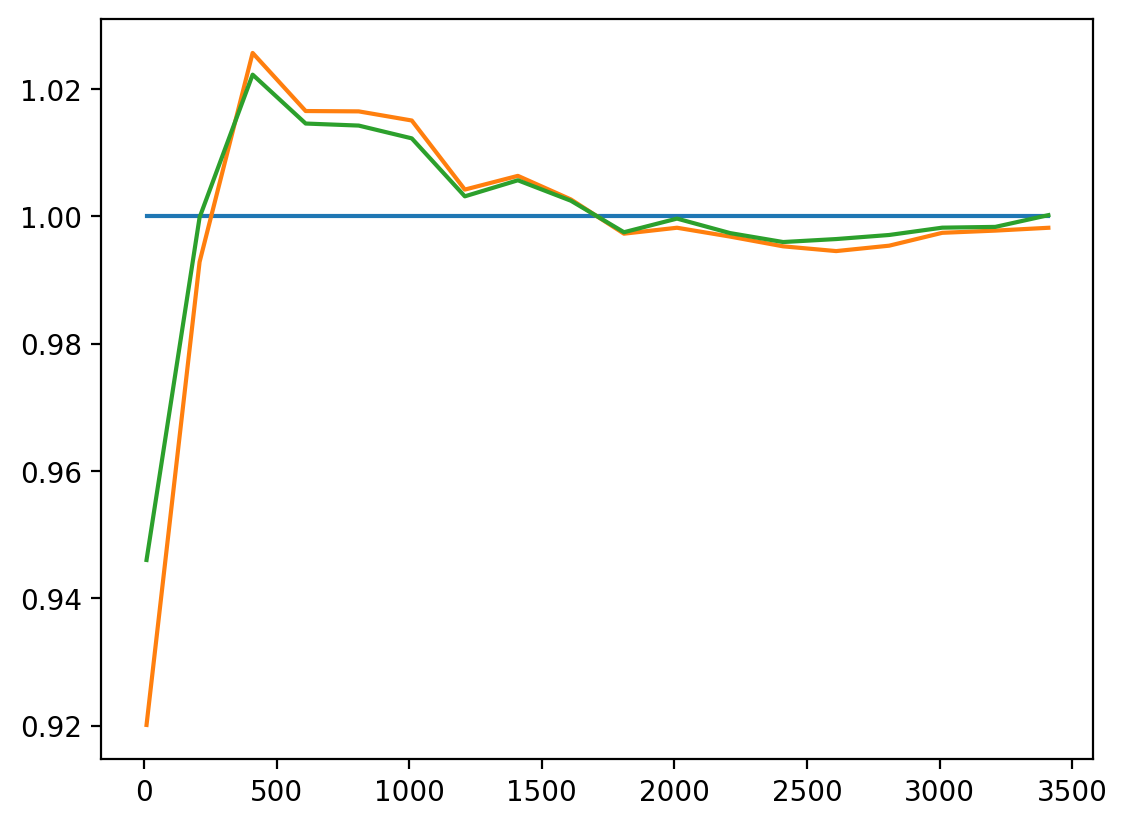

In [805]:
ALMCS0 = ALMCS[0]
for it in [0, 1, 2]:
    plt.plot(Ls, ALMCS[it]/ALMCS0, label = "MC, it = %d"%it)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_45753/1359440061.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  plt.plot(r_gg_true**-1.)


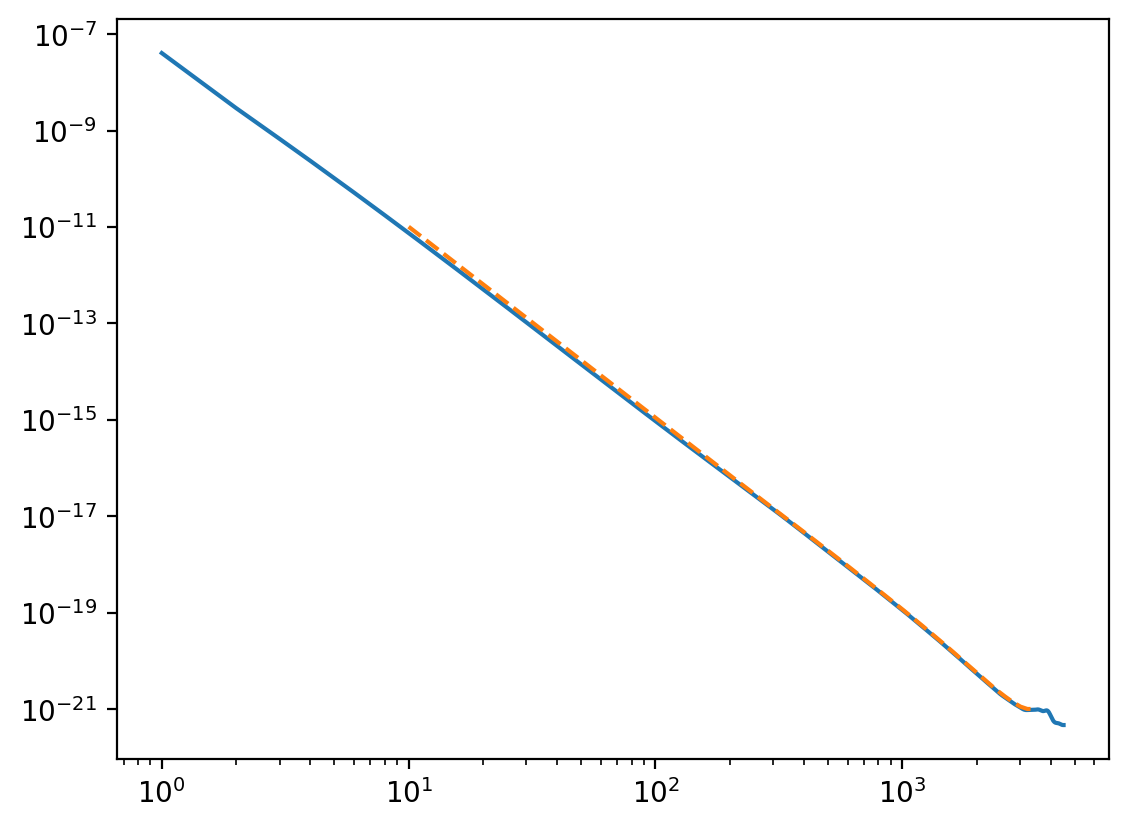

In [802]:
plt.plot(r_gg_true**-1.)
plt.loglog(Ls, ALMCS[0], ls = '--')

In [680]:
rginvinterp = np.interp(Ls, np.arange(len(r_gg_true**-1.)), r_gg_true**-1.)
rginvinterp/ALMCS[0]

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_45753/1471399043.py:1: RuntimeWarning: divide by zero encountered in reciprocal
  rginvinterp = np.interp(Ls, np.arange(len(r_gg_true**-1.)), r_gg_true**-1.)


array([0.74067958, 0.92819597, 0.9578897 , 0.95751935, 0.96281706,
       0.96610098, 0.95979264, 0.96483106, 0.9629416 , 0.957701  ,
       0.96270785, 0.9561824 , 0.95505887, 0.95795848, 0.95354707,
       0.95478673, 0.95168547, 0.95739686])

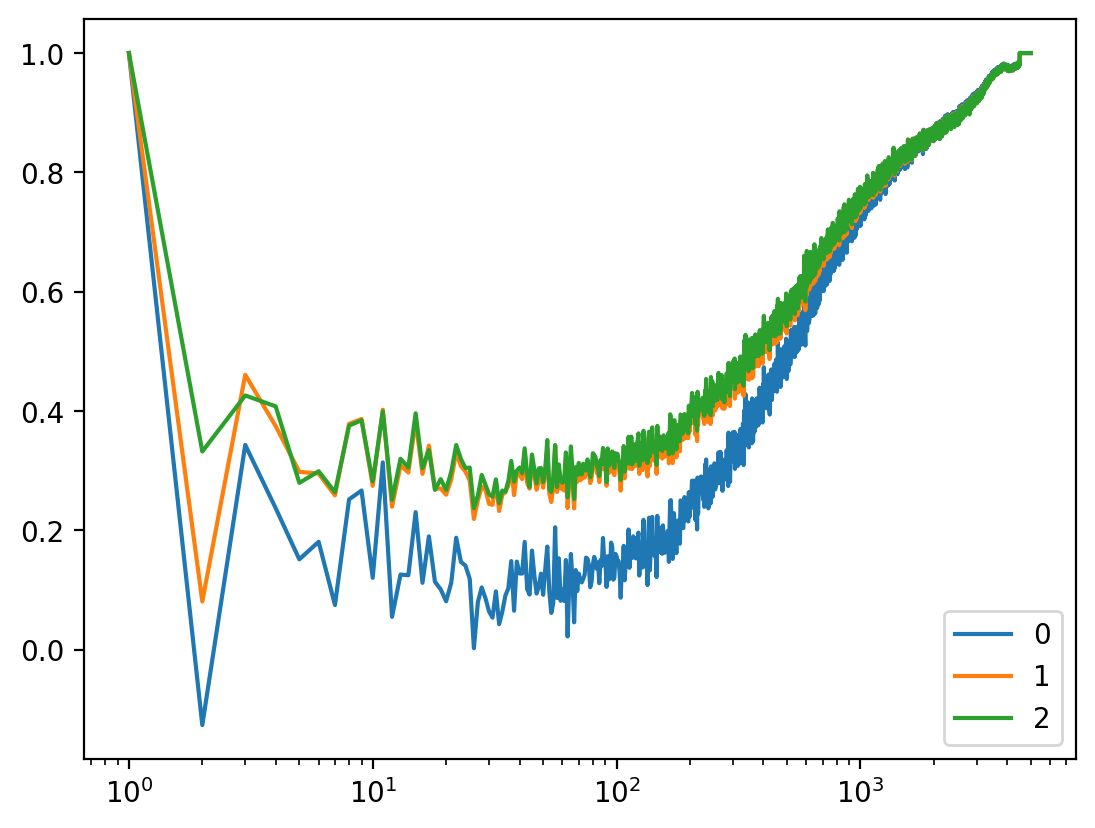

In [698]:
for ii in range(3):
    ll = np.arange(1, 5000, 1)
    plt.plot(ll, 1-Wss[ii](ll), label = ii)
plt.xscale("log")
plt.legend()

In [741]:
filter_batch = lambda x: (x >= lmin) & (x <= lmax)
#filter_batch = lambda x: (x >= lmin) & (x <= 3000)

In [742]:
@np.vectorize
def integrate_bispectrum_kkk(l1, l2, l3, model = 'TR'):
    bispectrum_at_ells_of_chi = lambda chi: chi**(-4)*integrated_bispectrum.Wkk(chi)**3*integrated_bispectrum.bispectrum_matter(l1/chi, l2/chi, l3/chi, 0, 0, 0, integrated_bispectrum.zofchi(chi), model = model)
    #return sinteg.quadrature(bispectrum_at_ells_of_chi, 0, integrated_bispectrum.chistar, maxiter = 50, rtol = 1e-8)[0]
    return sinteg.quadrature(bispectrum_at_ells_of_chi, 1e-12, integrated_bispectrum.chistar, maxiter = 100, miniter = 50, rtol = 1e-12)[0]

In [807]:
nitn, neval = 2e1, 1e3

iters_n32 = {}

bpmodel = "GM"

for ii in range(1):

    gradientTT = gradientTTs[ii]

    noise_component = ti.get_noise(ti.L, noise, beam)

    lpartial, ttpartial = np.loadtxt(f"tt_partial_{ii}.txt", unpack = True)
    ttpartial_interp = np.interp(ti.L, lpartial, ttpartial)# if ii == 0 else uTT(ti.L)
    

    @numba.jit(nopython = True)
    def tTTinterp(l):
        return interp(ti.L, ttpartial_interp+noise_component, l) 

    @numba.jit(nopython = True)
    def noiseinterp(l):
        return interp(ti.L, noise_component, l) 

    #model = "SC"
    models = [bpmodel]#, "SC", "GM"]#, "SC", "GM"]#, "SC"]#, "SC", "GM"]
    indices = {"TR": 0, "SC": 1, "GM": 2}

    results_n32 = {}


    for model in models:

        index = indices[model]
        
        print("Working on model", model, ", index", index)

        keys = ["B", "PB"]
        NTOT = {k: [] for k in keys}

        #bispec_special = lambda l1, l2, l3: 8/(l1*l2*l3)**2*integrate_bispectrum_kkk(l1, l2, l3, model = bpmodel)

        for LL in Ls:
            @vegas.batchintegrand
            def integrand(x):
                l1, l2, theta1, theta2 = x.T
                cos1, cos2 = np.cos(theta1), np.cos(theta2)
                sin1, sin2 = np.sin(theta1), np.sin(theta2)
                
                l5 = np.sqrt((l1*cos1-l2*cos2)**2+(l1*sin1-l2*sin2)**2)
                l4 = np.sqrt(LL**2+l2**2-2*LL*l2*cos2)
                l3 = np.sqrt(LL**2+l1**2-2*LL*l1*cos1)

                l2_dot_L = (LL*l2*cos2)
                l4_dot_L = (-l2_dot_L + LL**2)

                response = (l4_dot_L*gradientTT(l4) + l2_dot_L*gradientTT(l2)) 
                filter = 1/(2*tTTinterp(l2)*tTTinterp(l4))
                gTTf = response*filter*filter_batch(l4)

                l1_dot_l2 = (l1*cos1*l2*cos2) + (l1*sin1*l2*sin2)
                l2_dot_l3 = l2_dot_L-l1_dot_l2
                l5_dot_l1 = l1**2-l1_dot_l2
                l5_dot_l3 = LL*l1*cos1-l2_dot_L-l1**2+l1_dot_l2


                fattore =  np.nan_to_num((1-Wss[ii](l1))*(1-Wss[ii](l3)))

                fattoreNoise = np.nan_to_num((Wss[ii](l1))*(Wss[ii](l3)))

                noisepart = noiseinterp(l5)*fattoreNoise

                cl5_XY = gradientTT(l5)*fattore#*filter_batch(l5) #uTT(l5)*filter_batch(l5)
                Cl2 = gradientTT(l2)#*filter_batch(l2) #uTT(l2)*filter_batch(l2)

                cl5_XY += noisepart
                Cl2 += noisepart

                productA1 = -l5_dot_l1*l5_dot_l3*1*1*cl5_XY*gTTf
                productC1 = l2_dot_l3*l1_dot_l2*2*(1*Cl2*gTTf)*1/2

                #born_term = bispectrum_Born(l1, l3, LL)*8/(l1*l3*LL)**2
                born_term = 0.

                #ff = 1+(1-Wsinterpiter1(l1))*(1-Wsinterpiter1(l3))
                #fattore =  np.nan_to_num((1-Wss[ii](l1))*(1-Wss[ii](l3)))# if ii > 0 else 1.
                fattore = 1.
                #fattore = np.sqrt(abs(fattore))
                #fattore = np.nan_to_num(Wss[ii](l1)*Wss[ii](l3))
                
                #L = np.ones_like(l1)*LL

                bispectrum_result = b3n.bispec_phi_general(l1, l3, LL, index)*fattore #b3n.bispec_phi_general(l1, l3, LL, index)*fattore#*ff #*(1+(1-rho2interp1(l1))*(1-rho2interp1(l3)))
                #bispectrum_result = 0.
                #print(bispectrum_result)

                bispectrum_total = (bispectrum_result+born_term)#*filter_batch(l3)

                common = l1*l2*bispectrum_result/(2*np.pi)**4
                common_total = l1*l2*bispectrum_total/(2*np.pi)**4

                #A1 = common*productA1
                #C1 = common*productC1
                result = (productA1+productC1)*common
                result_total = (productA1+productC1)*common_total
                #return [common*productA1, common*productC1]
                return {"B": result, "PB": result_total} #{'A1': common*productA1, 'C1': common*productC1}
            result = integ(integrand, nitn = nitn, neval = neval)
            for k in keys:
                NTOT[k] += [result[k].mean]
            
            #NA1 += [result['A1'].mean]
            #NC1 += [result['C1'].mean]
        for k in keys:
            NTOT[k] = np.array(NTOT[k])
        results_n32[model] = NTOT
        
    iters_n32[ii] = results_n32

Working on model GM , index 2


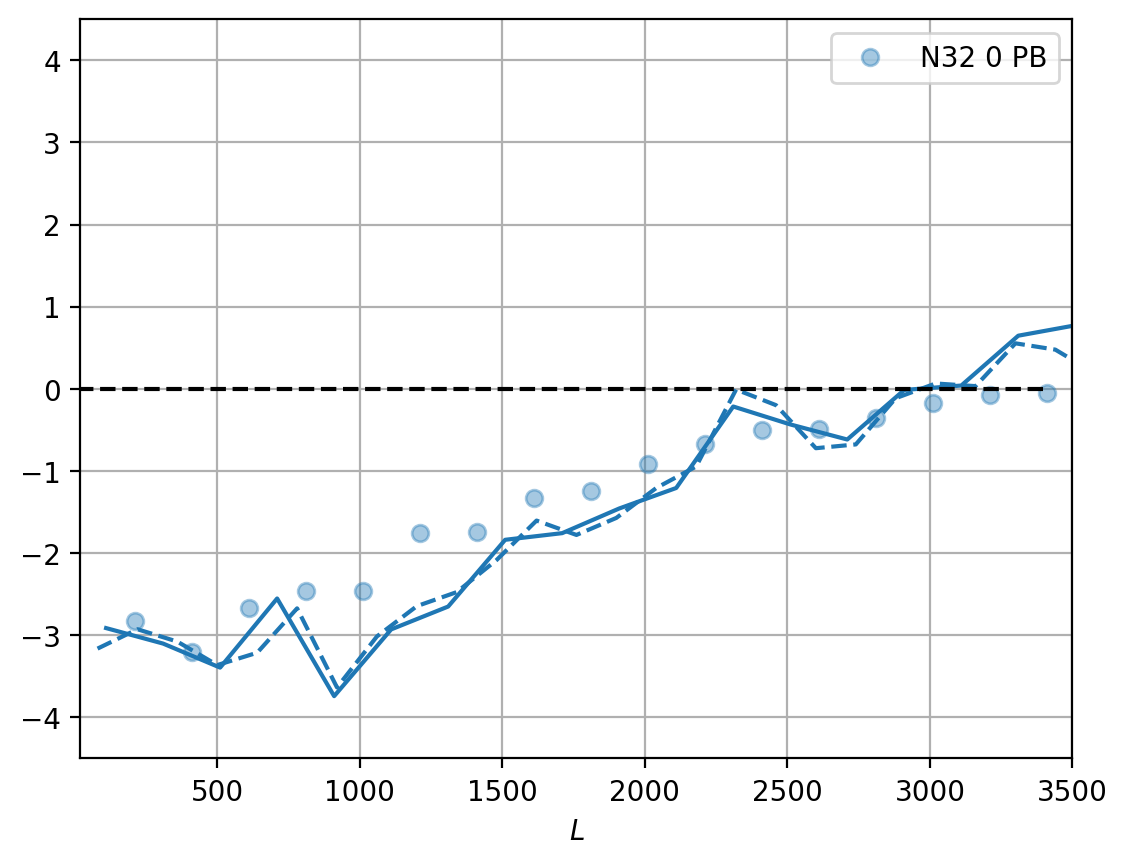

In [808]:
terms = ["PB"] #, "B"]
ppinterp = np.interp(Ls, ti.l, ti.pp)
dataold = np.loadtxt("cross_n32_.txt").T

somma = 0.
for ii, NTOT in iters_n32.items():
    for term in terms:
        somma = (NTOT[bpmodel][term])/ppinterp*100#*(Wss[ii](Ls) if ii == 0 else 1.) #*Wss[ii](Ls) if ii < 1 else 1. #*Wss[ii](Ls)
        fac = ALMCS[ii]
        #fac = 1.
        p = plt.plot(Ls, somma*fac, label = f'N32 {ii} {term}', alpha = 0.4, ls = "", marker = "o")
        #plt.plot(Ls, somma*rginvinterp, label = f'N32 {ii} {term}', alpha = 0.4, ls = "", marker = "o")
    color = p[0].get_color()
    data = np.loadtxt(f"/Users/omard/Documents/projects/n32plots/data/tt/binned_tt_n32_cross_born_{ii}.txt")
    elbin, valuebase = data[:, 0], data[:, 1]
    plt.plot(elbin, valuebase*100, color = color)
    plt.plot(dataold[0], dataold[ii+1]*100, color = color,ls = "--")

plt.plot(Ls, np.zeros_like(Ls), ls = '--', color = 'black')

plt.legend()
plt.xlabel(r"$L$")
plt.xlim(20, 3500)
plt.ylim(-4.5, 4.5)
plt.grid()

In [ ]:
#results_n32_pb = results_n32.copy()

In [ ]:
results_n32.keys()

dict_keys(['TR'])

In [ ]:
#iter2TR = results_n32[model]
#plt.title("Effect on n32 cross LSS TR when increasing number of iterations using grad TT spectra")
#iter8TR = results_n32["TR"]
#plt.plot(Ls, ALMCS[8]*iter8TR/ppinterp, label = "8")
#plt.plot(Ls, ALMCS[2]*iter2TR/ppinterp, label = "2")
#plt.plot(Ls, ALMCS[0]*iter0TR/ppinterp, label = "0")
#plt.plot(Ls, Ls*0., "k--")
#plt.legend()

In [ ]:
#l, potential = np.loadtxt('/Users/omard/Downloads/potential_from_camb_demuni.txt', unpack = True)
#ppinterp = np.interp(Ls, l, potential)

(20, 4000)

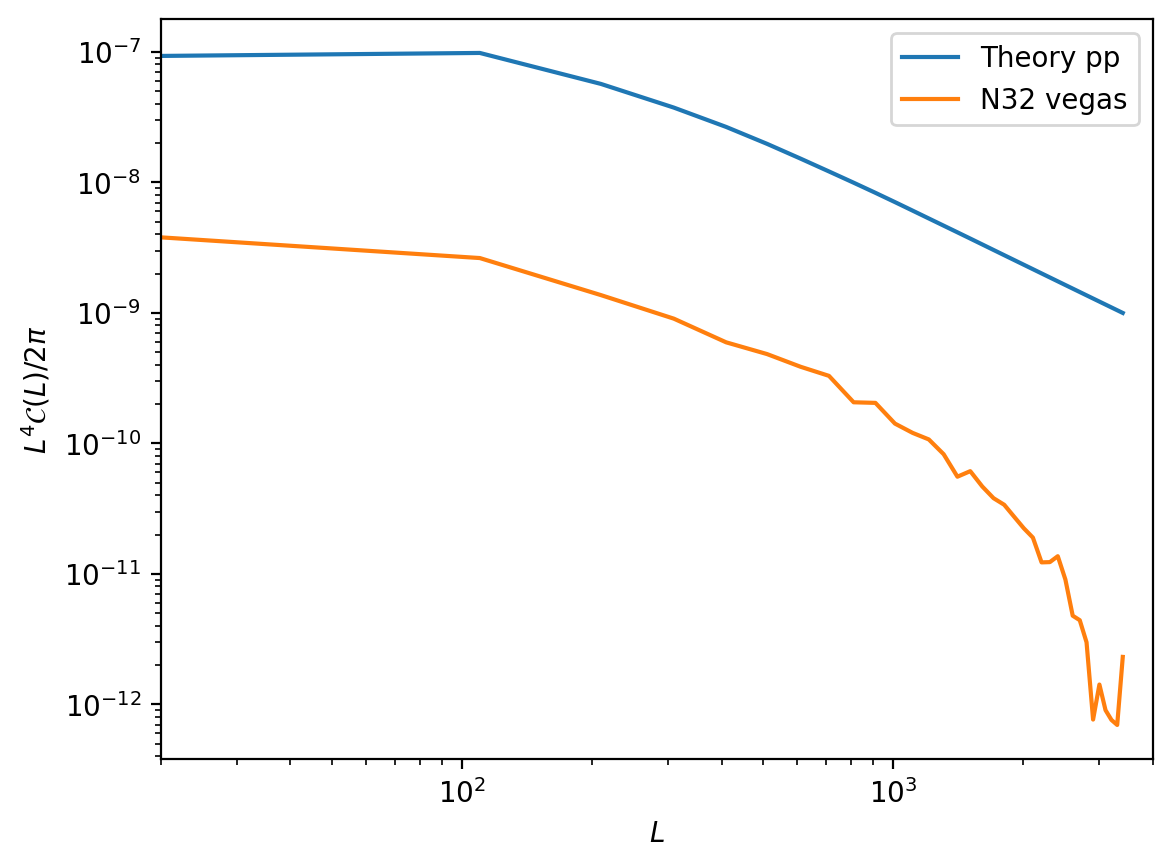

In [ ]:
plt.loglog(Ls, Ls**4*ppinterp/2/np.pi, label = 'Theory pp')
#plt.loglog(l, l**4*potential/2/np.pi, label = 'Theory potential')
plt.loglog(Ls, Ls**4*ALinterp*abs(NTOT["B"])/2/np.pi, label = 'N32 vegas')

#plt.loglog(Ls, Ls**4*ALinterp*abs((NA1+NC1))/2/np.pi, label = 'N32 vegas')

plt.legend()
plt.ylabel(r"$L^4\mathcal{C}(L)/2\pi$")
plt.xlabel(r"$L$")
plt.xlim(20, 4000)

In [ ]:
from scipy import signal
import scipy

def bin_theory(l, lcl, bin_edges):
    sums = scipy.stats.binned_statistic(l, l, statistic = 'sum', bins = bin_edges)
    cl = scipy.stats.binned_statistic(l, lcl, statistic = 'sum', bins = bin_edges)
    cl = cl[0]/sums[0]
    return cl

bin_edges = np.arange(10, 4000, 140)

In [ ]:
llinterp = np.arange(0, Ls.max(), 1)
from scipy.interpolate import InterpolatedUnivariateSpline
interpolating = InterpolatedUnivariateSpline(Ls, ALinterp**-1.*(NTOT["B"]), ext = 1)
clbinned = bin_theory(llinterp, llinterp*interpolating(llinterp), bin_edges)

clppbinned = bin_theory(ti.l, ti.l*ti.pp, bin_edges)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_11613/3102191132.py:7: RuntimeWarning: invalid value encountered in divide
  cl = cl[0]/sums[0]


In [ ]:
#np.savetxt("n32TR.txt", np.c_[Ls, ALinterp*(NA1+NC1)])
#np.savetxt("n32SC.txt", np.c_[Ls, ALinterp*(NTOT)])

In [ ]:
n32TR, n32SC = np.loadtxt("n32TR.txt")[:, 1], np.loadtxt("n32SC.txt")[:, 1]

In [ ]:
nbodykappa = np.loadtxt("kappa_first.txt")

In [ ]:
#prova = ALinterp*v/ppinterp*100

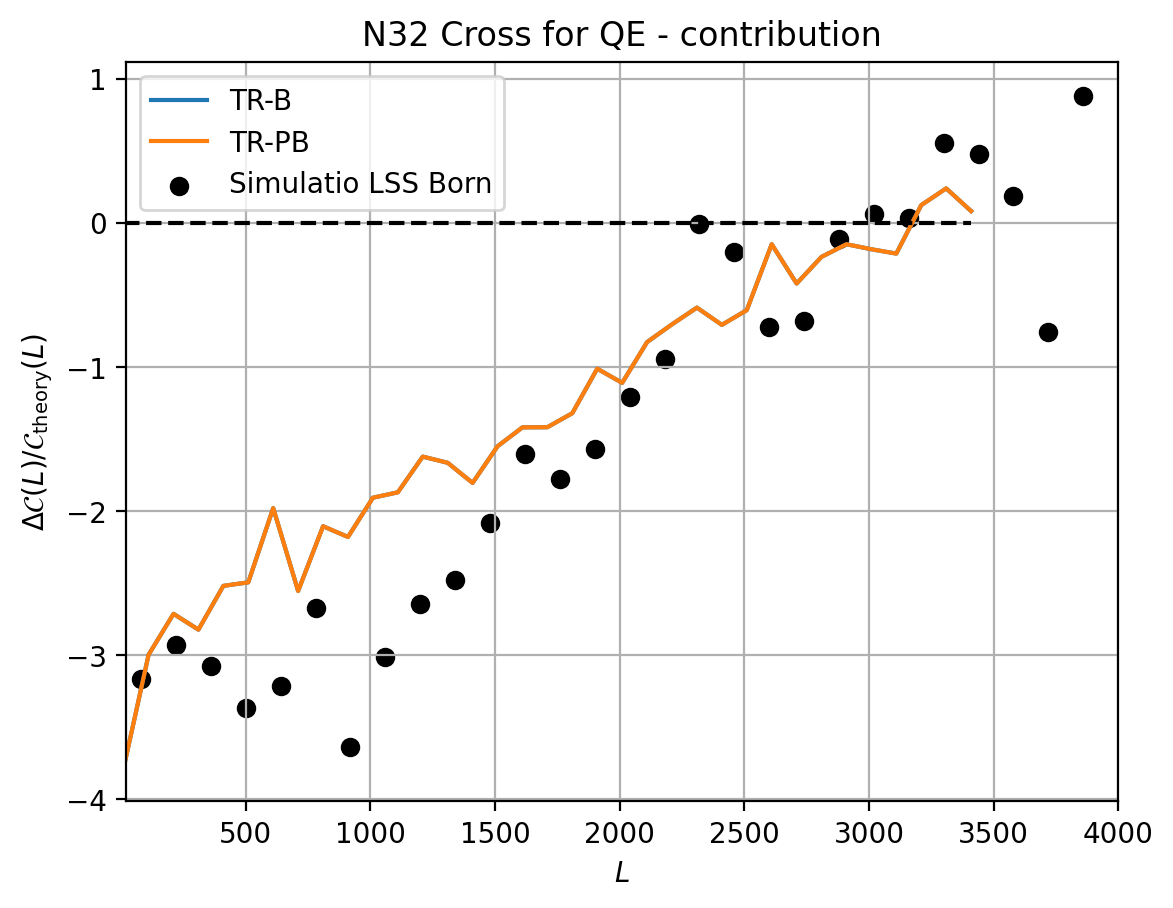

In [ ]:
plt.title("N32 Cross for QE - contribution")
#plt.plot(Ls, (n32TR)/ppinterp*100, label = 'Analytical Bias TR')
#plt.plot(Ls, (n32SC)/ppinterp*100, label = 'Analytical Bias SC')

for k, v in results_n32.items():
   for kk in v.keys():
       plt.plot(Ls, ALinterp*v[kk]/ppinterp*100, label = f"{k}-{kk}")
   #plt.plot(Ls, ALMCS[0]*v/ppinterp*100, label = k)
   #plt.plot(Ls, ALMCS[0]*results_n32_pb[k]/ppinterp*100, label = f"{k}-PB")



#plt.plot(Ls, ALMCS[0]*results_n32["TR"]/ppinterp*100)


#plt.plot(elsims, clbinned/clppbinned*100)
datafromsims = np.loadtxt("cross_n32_.txt")
elsims, n32qe = datafromsims[:, 0], datafromsims[:, 1]
plt.scatter(elsims, n32qe*100, label = 'Simulatio LSS Born', color = 'k')
plt.ylabel(r"$\Delta\mathcal{C}(L)/\mathcal{C}_{\rm theory}(L)$")
plt.plot(Ls, Ls*0, 'k--')
plt.xlabel(r"$L$")
plt.grid(True)
plt.legend()
plt.xlim(20, 4000)
plt.savefig("figures/crossLSS.png", dpi = 300, bbox_inches = 'tight')

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_77790/466414819.py:24: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/comparison_sims.png", dpi = 300, tight_layout = True)


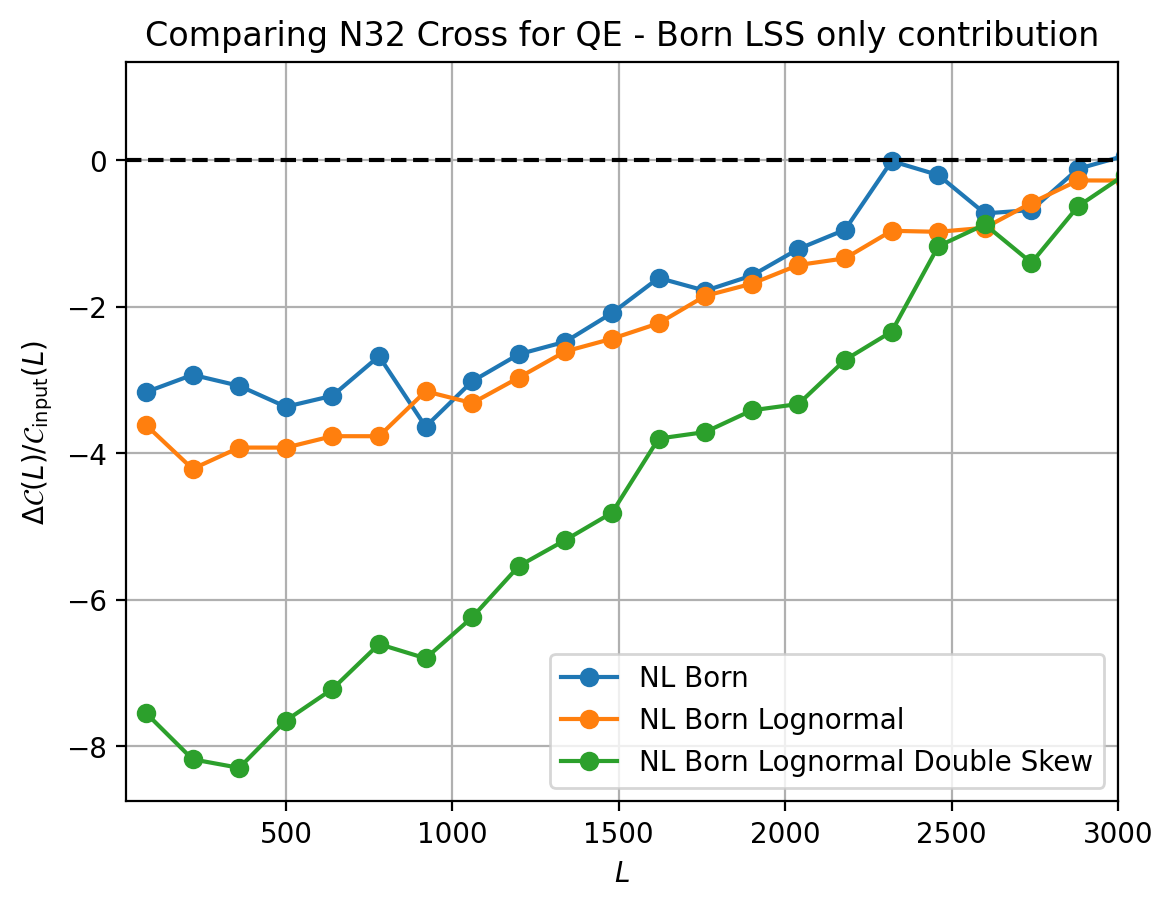

In [ ]:
plt.title("Comparing N32 Cross for QE - Born LSS only contribution")
#plt.plot(Ls, (n32TR)/ppinterp*100, label = 'Analytical Bias TR')
#plt.plot(Ls, (n32SC)/ppinterp*100, label = 'Analytical Bias SC')

datafromsims = np.loadtxt("cross_n32_.txt")
elsims, n32qe = datafromsims[:, 0], datafromsims[:, 1]
plt.plot(elsims, n32qe*100, label = 'NL Born', marker = 'o')

datafromsims = np.loadtxt("cross_n32_log.txt")
elsims, n32qe = datafromsims[:, 0], datafromsims[:, 1]
plt.plot(elsims, n32qe*100, label = 'NL Born Lognormal', marker = 'o')

datafromsims = np.loadtxt("cross_n32_logdoubleskew.txt")
elsims, n32qe = datafromsims[:, 0], datafromsims[:, 1]
plt.plot(elsims, n32qe*100, label = 'NL Born Lognormal Double Skew', marker = 'o')


plt.ylabel(r"$\Delta\mathcal{C}(L)/\mathcal{C}_{\rm input}(L)$")
plt.plot(Ls, Ls*0, 'k--')
plt.xlabel(r"$L$")
plt.grid(True)
plt.legend()
plt.xlim(20, 3000)
plt.savefig("figures/comparison_sims.png", dpi = 300, tight_layout = True)

/var/folders/5s/mpby42n15_ng7rv494cv19tw0000gn/T/ipykernel_77790/84822318.py:20: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig("figures/comparison_sims_iterations.png", dpi = 300, tight_layout = True)


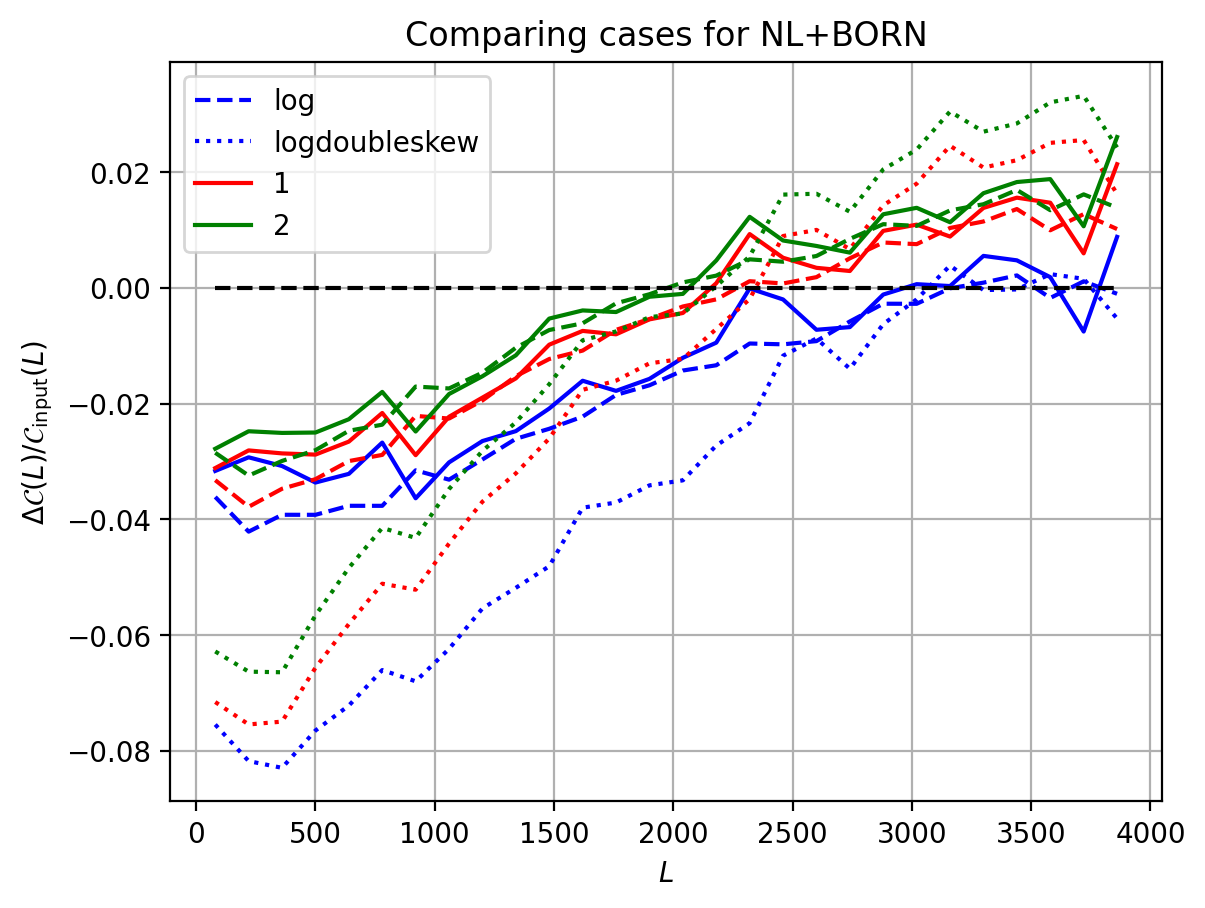

In [ ]:
colors = ["blue", "red", "green"]
styles = ["-", "--", ":"]

cases_to_compare = ["", "log", "logdoubleskew"]

for iteration in [0, 1, 2]:
    plt.title(f"Comparing cases for NL+BORN")
    for c_, style in zip(cases_to_compare, styles):
        data = np.loadtxt(f"cross_n32_{c_}.txt")
        elbin, valuebase = data[:, 0], data[:, iteration+1]
        plt.plot(elbin, valuebase, label = c_ if iteration == 0 else (iteration if c_ == cases_to_compare[0] else None), color = colors[iteration], ls = style)


plt.ylabel(r"$\Delta\mathcal{C}(L)/\mathcal{C}_{\rm input}(L)$")
plt.plot(elbin, elbin*0, 'k--')
plt.xlabel(r"$L$")

plt.legend()
plt.grid(True)
plt.savefig("figures/comparison_sims_iterations.png", dpi = 300, tight_layout = True)


## Postborn

In [40]:
def Ma1a2kappa(weights, Wa_ofchi, Wkappa_ofchi, Ca2kappa_Lprime_ofchi, Pm):
    return np.dot(weights, Wa_ofchi, Wkappa_ofchi, Ca2kappa_Lprime_ofchi, Pm)

def Ca2kappa_Lprime_atchi(Ls, chis, zs_at_chis, gaussian_weights, Wa_ofchi, Wkappa_ofchi, Pminterpolator, kmax = 100):

    result = np.empty(Ls.shape)
    kernel = Wa_ofchi*Wkappa_ofchi/chis**2
    Ns = len(Ls)
    w = np.ones(chis.shape)
    for i in range(Ns):
        L = Ls[i]
        ks = (L+1/2)/chis
        w[:] = 1
        w[ks < 1e-4] = 0
        w[ks >= kmax] = 0
        result[i] = np.dot(gaussian_weights, Pminterpolator(zs_at_chis, ks)*kernel*w/ks**4)
    result *= Ls**4 
    return result


def Ca2kappa_Lprime_atchi_from_chisource(Ls, chis, zs_at_chis, gaussian_weights, chi_source_A, chi_source_B, Pminterpolator, kmax = 100):
    Wa_ofchi = (1/chis-1/chi_source_A)
    Wkappa_ofchi = (1/chis-1/chi_source_B)
    return Ca2kappa_Lprime_atchi(Ls, chis, zs_at_chis, gaussian_weights, Wa_ofchi, Wkappa_ofchi, Pminterpolator, kmax)



results = integrated_bispectrum.results

In [41]:
import camb
from camb import model as cmodel

def gaussxw(a, b, N):
    x, w = np.polynomial.legendre.leggauss(N)
    return 0.5*(b-a)*x + 0.5*(b+a), 0.5*(b-a)*w

Nquadrature = 50
chistar = integrated_bispectrum.chistar
chis, gaussian_weights = gaussxw(0, chistar, Nquadrature)
zs_at_chis = results.redshift_at_comoving_radial_distance(chis)

PK = camb.get_matter_power_interpolator(integrated_bispectrum.pars, nonlinear = True, 
    hubble_units=False, k_hunit=False, kmax=kmax,k_per_logint=None,
    var1=cmodel.Transfer_Weyl,var2=cmodel.Transfer_Weyl, zmax=1100)


Pminterpolator = lambda z, k: PK.P(z, k, grid = False)

In [42]:
Lprimes = np.arange(1, 5000, 5)

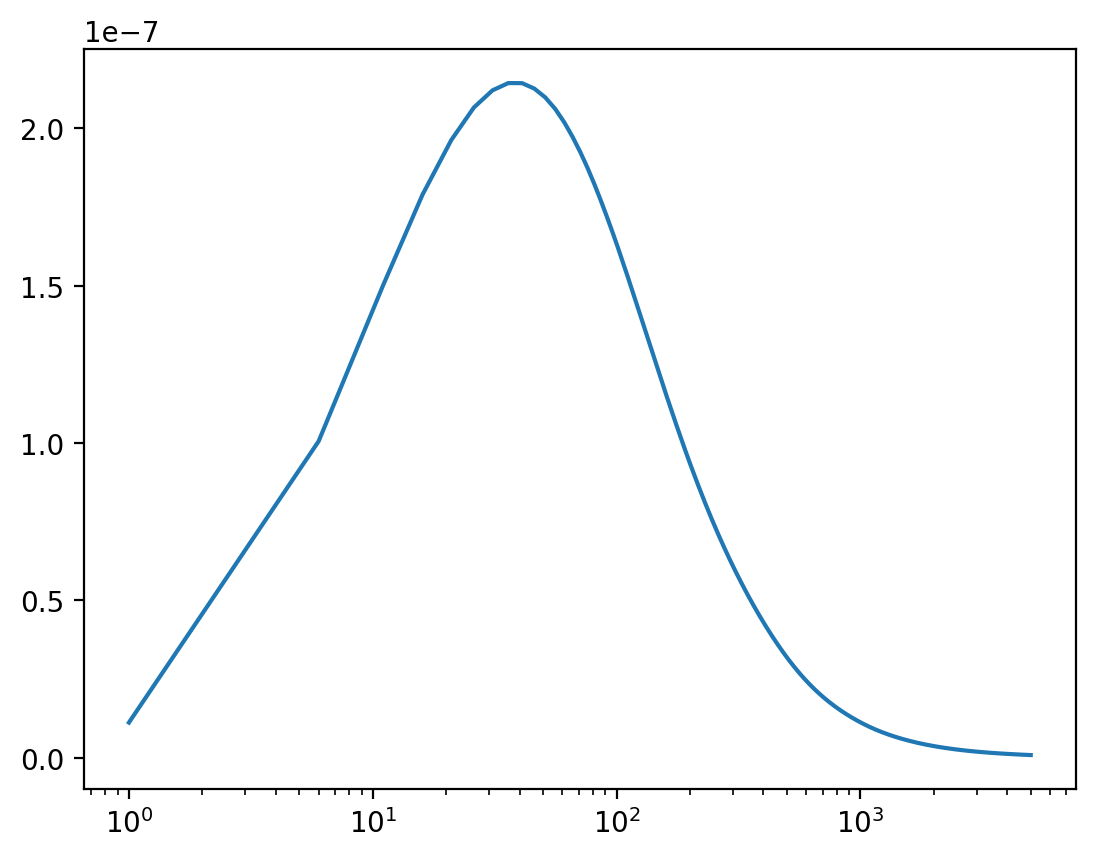

In [43]:
nchimax = 100

chimaxs = np.linspace(0 ,chistar, nchimax)

cls = np.zeros((nchimax, Lprimes.size))

chi_source = chistar
Wa_ofchi = (1/chis-1/chi_source)
Wkappa_ofchi = (1/chis-1/chi_source)
clkappa = Ca2kappa_Lprime_atchi(Lprimes, chis, zs_at_chis, gaussian_weights, Wa_ofchi, Wkappa_ofchi, Pminterpolator)
plt.semilogx(Lprimes, clkappa)

In [44]:
def cl_kappa(chi_source, chi_source2=None):
    chi_source = np.float64(chi_source)
    if chi_source2 is None: 
        chi_source2 = chi_source
    else:
        chi_source2 = np.float64(chi_source2)
    chis = np.linspace(0,chi_source,2*100, dtype=np.float64)
    zs=results.redshift_at_comoving_radial_distance(chis)
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    win = (1/chis-1/chi_source)*(1/chis-1/chi_source2)/chis**2
    cl=np.zeros(Lprimes.shape)
    w = np.ones(chis.shape)
    for i, l in enumerate(Lprimes):
        k=(l+0.5)/chis
        w[:]=1
        w[k<1e-4]=0
        w[k>=kmax]=0
        cl[i] = np.dot(dchis,
            w*PK.P(zs, k, grid=False)*win/k**4)
    cl*= Lprimes**4 #(ls*(ls+1))**2
    return cl

In [45]:
nchimax = 100*2
chimaxs = np.linspace(0 ,chistar, nchimax)
cls = np.zeros((nchimax,Lprimes.size))
for i, chimax in enumerate(chimaxs[1:]):
    #cl = cl_kappa(chimax)
    #p = plt.semilogx(Lprimes,cl, alpha = 0.4)

    chis, gaussian_weights = gaussxw(0, chimax, Nquadrature)
    zs_at_chis = results.redshift_at_comoving_radial_distance(chis)
    clkappa = Ca2kappa_Lprime_atchi_from_chisource(Lprimes, chis, zs_at_chis, gaussian_weights, chimax, chistar, Pminterpolator)
    cls[i+1,:] = clkappa
    #plt.semilogx(Lprimes, clkappa, ls = '--', color = p[0].get_color())

cls[0,:]=0    


In [46]:
cls #chi as row, L as column

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.32220574e-11, 5.18346568e-11, 3.12154620e-11, ...,
        4.44888250e-15, 4.44888429e-15, 4.44888607e-15],
       [3.15545816e-10, 2.49291790e-10, 1.39605240e-10, ...,
        4.53510643e-14, 4.53510825e-14, 4.53511007e-14],
       ...,
       [1.11602916e-08, 1.00261031e-07, 1.49344937e-07, ...,
        8.53215884e-10, 8.51854116e-10, 8.50495851e-10],
       [1.11720478e-08, 1.00421538e-07, 1.49633569e-07, ...,
        8.56937264e-10, 8.55568392e-10, 8.54203043e-10],
       [1.11836802e-08, 1.00580599e-07, 1.49919499e-07, ...,
        8.60608239e-10, 8.59232358e-10, 8.57860021e-10]])

In [47]:
import scipy
cl_chi = scipy.interpolate.RectBivariateSpline(chimaxs, Lprimes, cls)


In [48]:
#Get M(l,l') matrix
chis, gaussian_weights = gaussxw(0, chistar, Nquadrature)
zs = results.redshift_at_comoving_radial_distance(chis)

win = (1/chis-1/chistar)**2/chis**2
cl = np.zeros(Lprimes.shape)
w = np.ones(chis.shape)
cchi = cl_chi(chis, Lprimes, grid = True)

M = np.zeros((Lprimes.size, Lprimes.size))

for i, l in enumerate(Lprimes):
    k = (l+0.5)/chis
    w[:] = 1
    w[k < 1e-4] = 0
    w[k >= kmax] = 0
    cl = np.dot(gaussian_weights*w*PK.P(zs, k, grid = False)*win/k**4, cchi)
    M[i,:] = cl*l**4 #(l*(l+1))**2

In [49]:
Mf = scipy.interpolate.RectBivariateSpline(Lprimes, Lprimes, np.log(M))
Msp = scipy.interpolate.RectBivariateSpline(Lprimes, Lprimes, M)

In [184]:
def get_angle_cos12(L1, L2, L3):
    return -(L1**2+L2**2-L3**2)/(2*L1*L2)

In [185]:
[0, 1, 2], [2, 1, 0], [0, 2, 1]

([0, 1, 2], [2, 1, 0], [0, 2, 1])

In [186]:
import itertools

def one_term_bispectrum_born(L1, L2, L3):
    cos12 = get_angle_cos12(L1, L2, L3)
    cos13 = get_angle_cos12(L1, L3, L2)
    cos23 = get_angle_cos12(L2, L3, L1)

    result = 2*cos12/(L1*L2)*(L1*L3*cos13*Msp(L1, L2)+L2*L3*cos23*Msp(L2, L1))
    return result

@np.vectorize
def bispectrum_Born(L1, L2, L3):
    Lslist = [L1, L2, L3]
    options = [[0, 1, 2], [2, 1, 0], [0, 2, 1]]
    return np.sum([one_term_bispectrum_born(Lslist[option[0]], Lslist[option[1]], Lslist[option[2]]) for option in options], axis = 0)


In [189]:
@np.vectorize
def bi_born(l1,l2,l3):
    cos12 = (l3**2-l1**2-l2**2)/2/l1/l2
    cos23 = (l1**2-l2**2-l3**2)/2/l2/l3
    cos31 = (l2**2-l3**2-l1**2)/2/l3/l1
    return  - 2*cos12*((l1/l2+cos12)*Msp(l1,l2,grid=False) + (l2/l1+cos12)*Msp(l2,l1, grid=False) )  \
            - 2*cos23*((l2/l3+cos23)*Msp(l2,l3,grid=False) + (l3/l2+cos23)*Msp(l3,l2, grid=False) )  \
            - 2*cos31*((l3/l1+cos31)*Msp(l3,l1,grid=False) + (l1/l3+cos31)*Msp(l1,l3 ,grid=False) ) 


@np.vectorize
def bi_born_2(l1,l2,l3):

    fac= 2.#check for cross

    cos12 = (l3**2-l1**2-l2**2)/2./l1/l2
    cos23 = (l1**2-l2**2-l3**2)/2./l2/l3
    cos31 = (l2**2-l3**2-l1**2)/2./l3/l1

    res1 = cos23/l2/l3*l1*(l3*cos31*Msp(l3,l2,grid=False) +l2*cos12*Msp(l2,l3,grid=False))*fac
    res2 = cos31/l1/l3*l2*(l3*cos23*Msp(l3,l1,grid=False) +l1*cos12*Msp(l1,l3,grid=False))*fac
    res3 = cos12/l2/l1*l3*(l1*cos31*Msp(l1,l2,grid=False) +l2*cos23*Msp(l2,l1,grid=False))*fac

    return res1+res2+res3


@np.vectorize
def bi_born_cross1(l1,l2,l3):

    fac= 2.#check for cross

    cos12 = (l3**2-l1**2-l2**2)/2./l1/l2
#        cos23 = (l1**2-l2**2-l3**2)/2./l2/l3
    cos31 = (l2**2-l3**2-l1**2)/2./l3/l1

    res = cos12*l2/l3*cos31*Msp(l1,l3,grid=False) \
        + cos31*l3/l2*cos12*Msp(l1,l2,grid=False)
    
    


    return res*fac

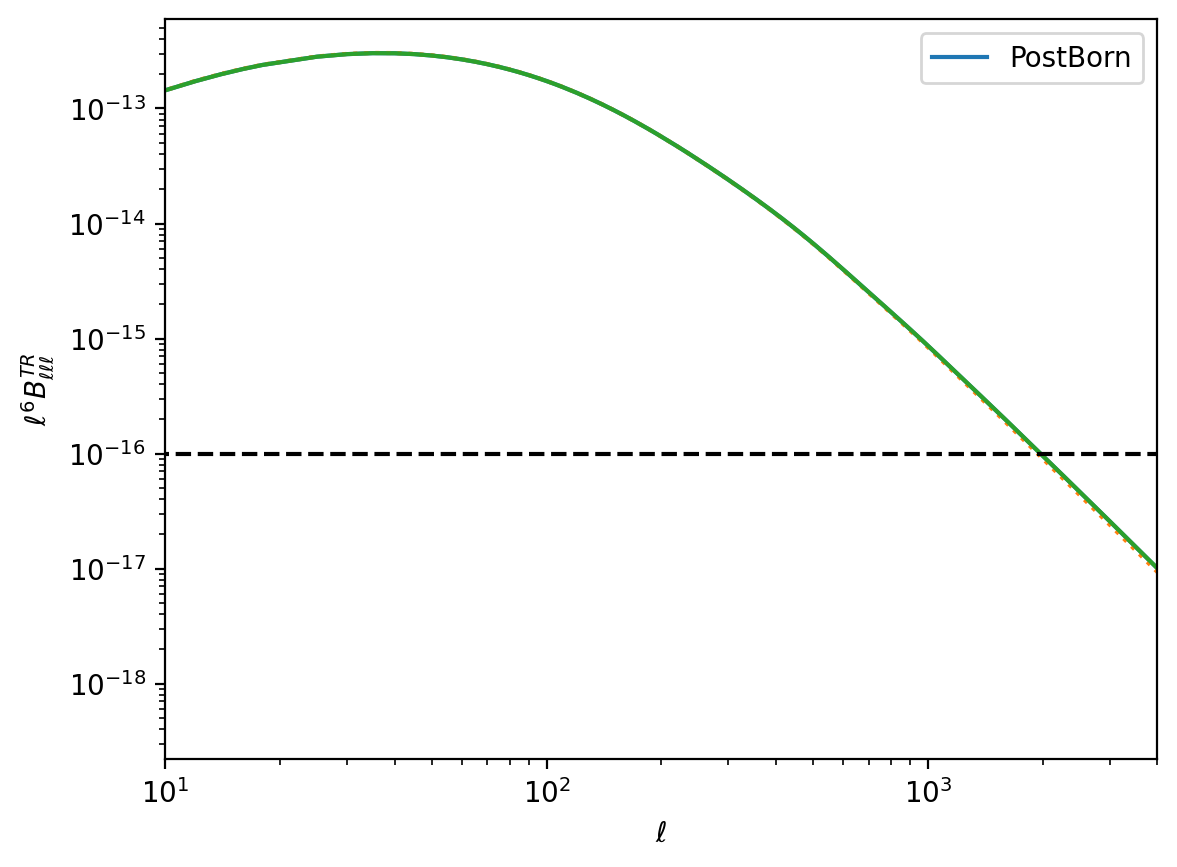

In [192]:

plt.plot(ls, bispectrum_Born(ls, ls, ls)*ls**6*8/(ls**3)**2, label = "PostBorn")

plt.plot(lsamp, testborn*ls**6*8/(ls**3)**2, ls = ":")

plt.plot(ls, bi_born_cross1(ls, ls, ls)*ls**6*8/(ls**3)**2*3)

plt.plot(ls, np.zeros_like(ls)+1e-16, color = 'black', ls = '--')

plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(10, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()

In [181]:
L1, L2, L3 = 4*np.ones(2), 200*np.ones(2), 30*np.ones(2)

In [188]:
bi_born(L1, L2, L3)/bispectrum_Born(L1, L2, L3)

array([1., 1.])

In [257]:
lsamp,testborn, test, test_SC, test_GM = np.loadtxt("/Users/omard/Downloads/cmbant-notebooks-f9fb945/equilateral_zstar.txt", unpack=True)

In [57]:
theta = np.pi/3
integrated_bispectrum.bispectrum_matter(1, 1, 1, theta, theta, theta, 0)/1e6

1.4480123273499406

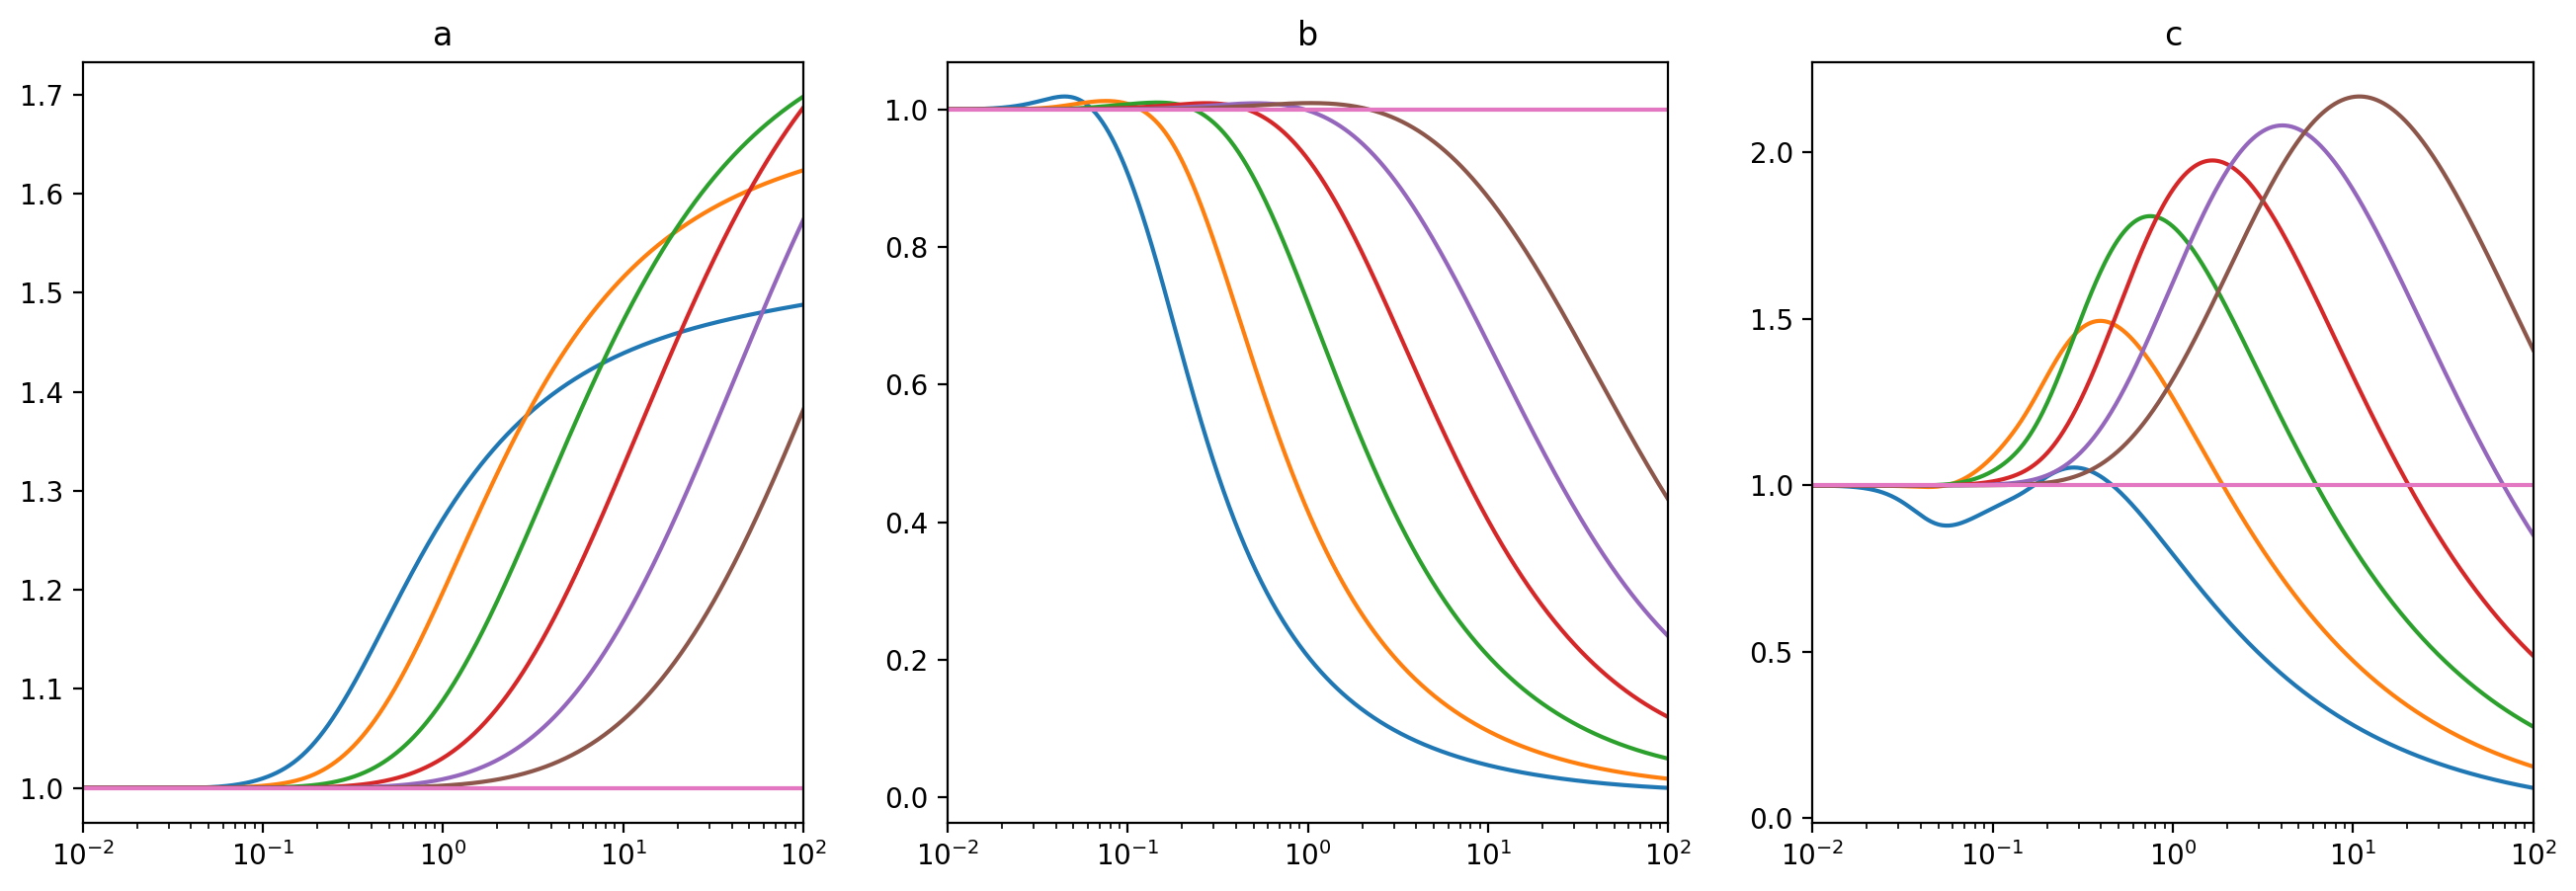

In [115]:
SC_fitsp = integrated_bispectrum.getfuncs("SC")
zmax_lss = 5.2
PKlin_k = np.logspace(-4, 2, 1000)
fig, axs = plt.subplots(1,3,figsize=(16,5))
for i, (ax, let) in enumerate(zip(axs,['a','b','c'])):
    for z in np.arange(zmax_lss+1):
        ax.semilogx(PKlin_k,SC_fitsp[i](z, PKlin_k))
        ax.set_xlim([1e-2,100])
    ax.set_title(let);

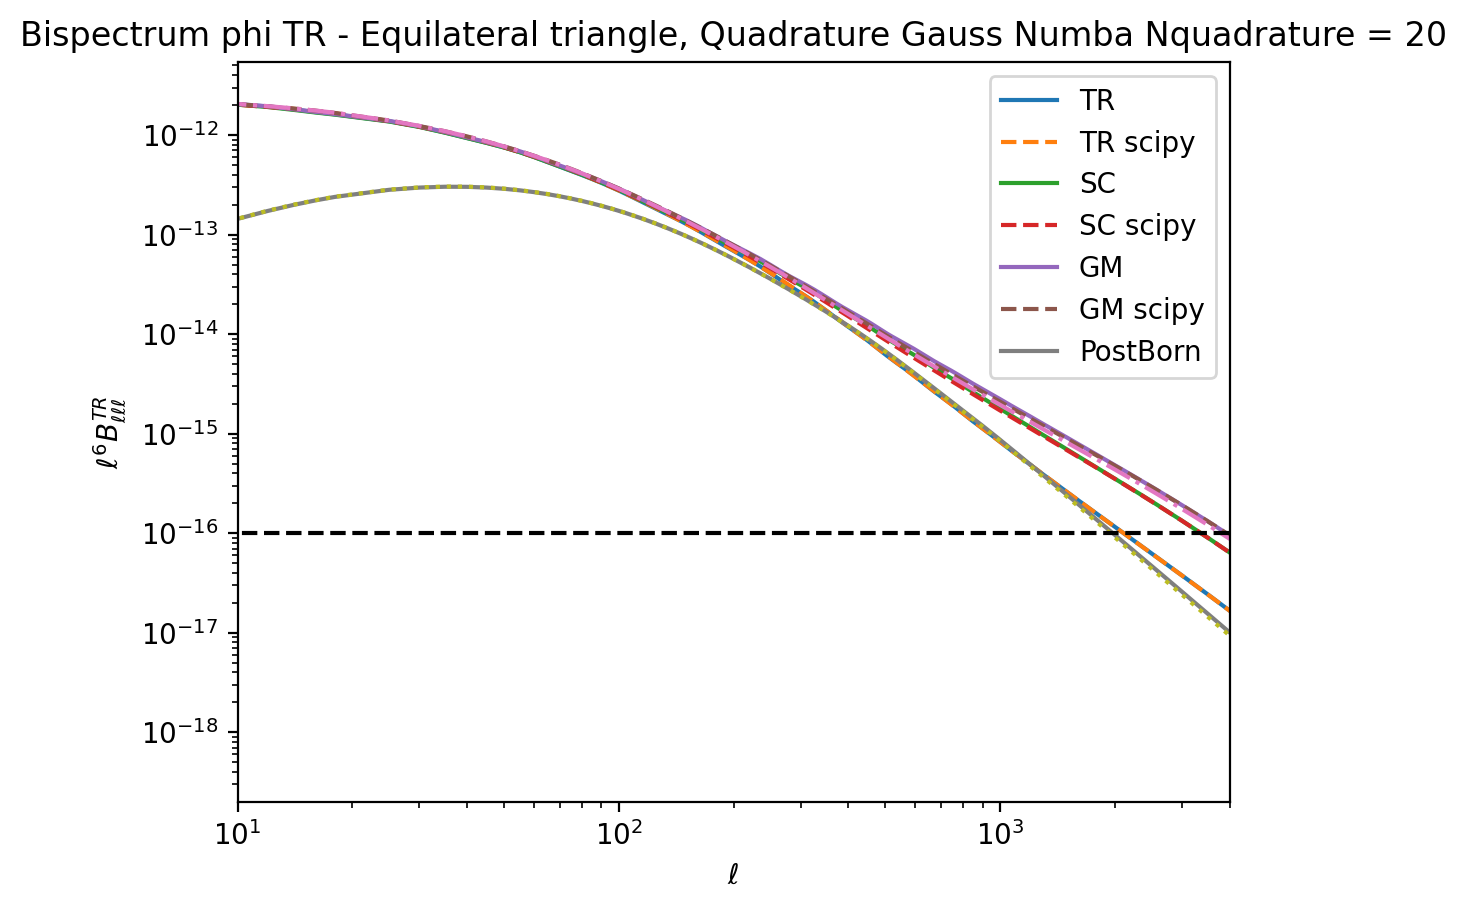

In [258]:
plt.title(f"Bispectrum phi TR - Equilateral triangle, Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
#for N in [10, 20, 30, 40]:
#    plt.plot(ls, ls**6*b3n.bispec_check_quadrature(ls, ls, ls, N), label = f"Quadrature Gauss Numba Nquadrature = {N}")
#plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls, ls), label = f"TR")
#plt.plot(ls, ls**6*b3n.bispec_phi_GM(ls, ls, ls), label = f"GM")

ls = lsamp

models = ['TR', 'SC', 'GM']
for i, model in enumerate(models):
    angle12, angle13, angle23 = np.pi/3, np.pi/3, np.pi/3
    calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls, ls, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, ls**6*b3n.bispec_phi_general(ls, ls, ls, i), label = f"{model}")
    plt.plot(ls, calculated*ls**6, label = model+" scipy", ls = '--')


plt.plot(ls, test_GM*8, ls = "-.")

plt.plot(ls, bispectrum_Born(ls, ls, ls)*ls**6*8/(ls**3)**2, label = "PostBorn")

plt.plot(lsamp, testborn*ls**6*8/(ls**3)**2, ls = ":")

plt.plot(ls, np.zeros_like(ls)+1e-16, color = 'black', ls = '--')

plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(10, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()
plt.savefig("figures/bispectrum_phi_TR_equilateral_triangle.png", dpi = 300)

In [260]:
lsamp,testborn, test, test_SC, test_GM = np.loadtxt("/Users/omard/Downloads/cmbant-notebooks-f9fb945/folded_zstar.txt", unpack=True)

In [265]:
import bispectrum_3D_numba

In [619]:
%timeit b3n.bispectrum_matter_cos_TR(1, 1/2, 1/2, -1, -1, 1., 0)

1.16 µs ± 21.4 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [620]:
%timeit integrated_bispectrum.bispectrum_matter(1, 1/2, 1/2, 0, 0, np.pi, 0)

57.1 µs ± 544 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


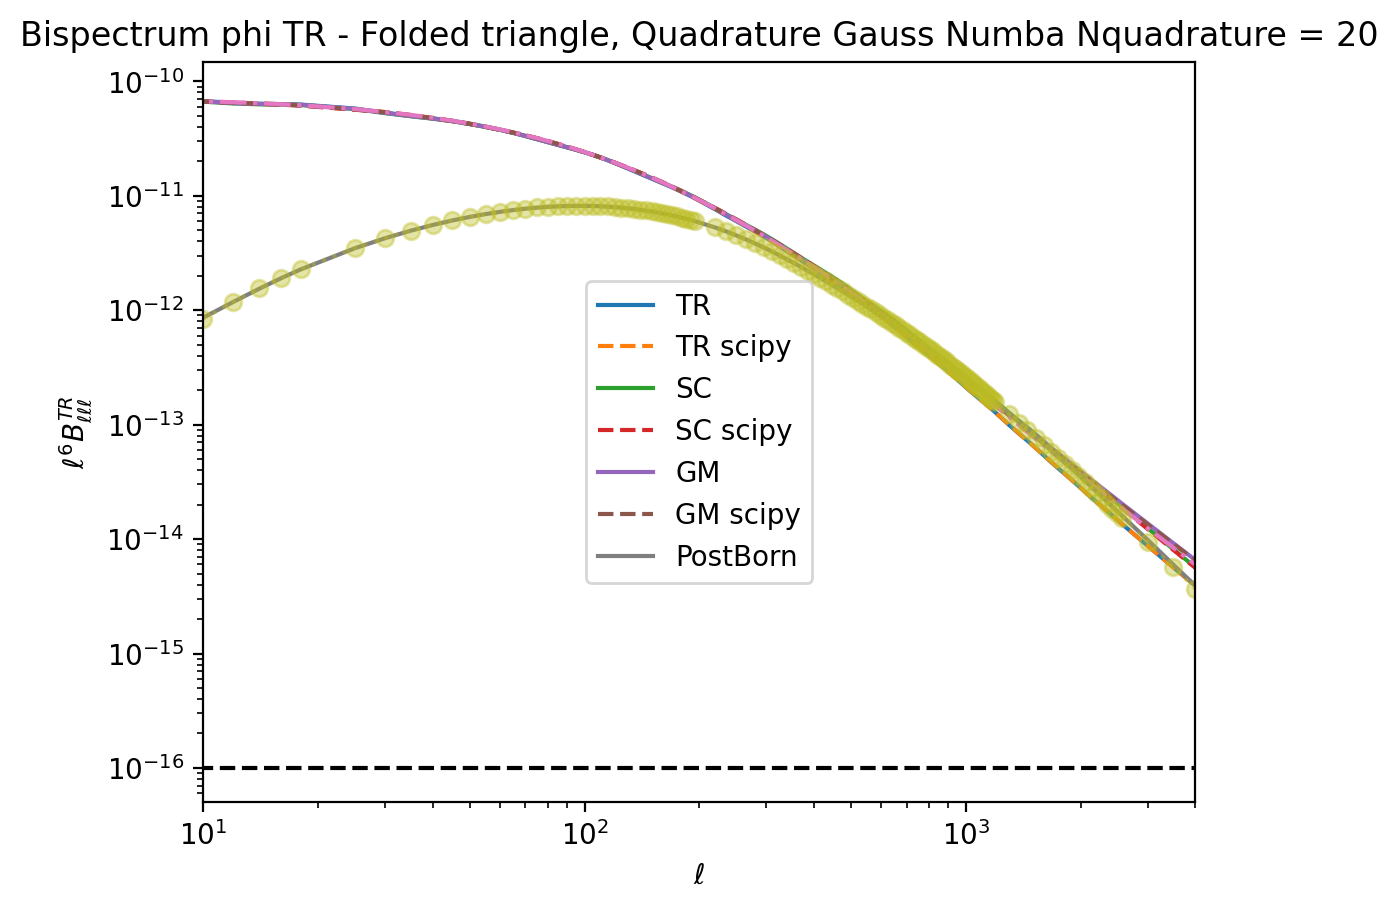

In [327]:
plt.title(f"Bispectrum phi TR - Folded triangle, Quadrature Gauss Numba Nquadrature = {b3n.Nquadrature}")
#for N in [10, 20, 30, 40]:
#    plt.plot(ls, ls**6*b3n.bispec_check_quadrature(ls, ls, ls, N), label = f"Quadrature Gauss Numba Nquadrature = {N}")
#plt.plot(ls, ls**6*b3n.bispec_phi_TR(ls, ls, ls), label = f"TR")
#plt.plot(ls, ls**6*b3n.bispec_phi_GM(ls, ls, ls), label = f"GM")

ls = lsamp

factor = (ls*(ls/2)*(ls/2))

models = ['TR', 'SC', 'GM']
for i, model in enumerate(models):
    angle12, angle13, angle23 = np.pi/6, np.pi/6, 2*np.pi/3
    calculated = 8/(factor)**2*integrate_bispectrum_kkk(ls, ls/2, ls/2, angle12, angle13, angle23, model = model)#list(map(integrate_bispectrum_kkk_single, ls))
    plt.plot(ls, ls**6*bispectrum_3D_numba.bispec_phi_general(ls, ls/2, ls/2, i), label = f"{model}")
    plt.plot(ls, calculated*ls**6, label = model+" scipy", ls = '--')


plt.plot(ls, test_GM*ls**6*8/(factor)**2, ls = "-.")

plt.plot(ls, -bispectrum_Born(ls, ls/2, ls/2)*ls**6*8/(factor)**2, label = "PostBorn")

plt.plot(lsamp, -testborn*ls**6*8/(factor)**2, ls = ":", marker = "o", alpha = 0.4)

plt.plot(ls, np.zeros_like(ls)+1e-16, color = 'black', ls = '--')

plt.yscale("log")
plt.xscale("log")
plt.ylabel(r"$\ell^6 B_{\ell\ell\ell}^{TR}$")
plt.xlabel(r"$\ell$")
plt.xlim(10, 4000)
#plt.loglog(ls, b3n.integrate_bispectrum_kkk_TR_cos_scipy_from_triangle(ls, ls, ls), label = "Scipy")
plt.legend()
plt.savefig("figures/bispectrum_phi_TR_folded_triangle.png", dpi = 300)

In [262]:
def get_angle_cos12(L1, L2, L3):
    return -(L1**2+L2**2-L3**2)/(2*L1*L2)

In [321]:
l1, l2, l3 = 10, 5, 5
cos12, cos13, cos23 = get_angle_cos12(l1, l2, l3), get_angle_cos12(l1, l3, l2), get_angle_cos12(l2, l3, l1)
angle12, angle13, angle23 = np.arccos(cos12), np.arccos(cos13), np.arccos(cos23)
calculated = 8/(ls**3)**2*integrate_bispectrum_kkk(ls, ls/2, ls/2, angle12, angle13, angle23, model = model)

In [317]:
get_angle_cos12(l1, l2, l3)

-1.0

In [320]:
angle23

nan

In [ ]:
l1, l2, l3 = 10, 5, 5
cos12, cos13, cos23 = get_angle_cos12(l1, l2, l3), get_angle_cos12(l1, l3, l2), get_angle_cos12(l2, l3, l1)
angle12, angle13, angle23 = np.arccos(cos12), np.arccos(cos13), np.arccos(cos23)
8/(l1*l2*l3)**2*integrate_bispectrum_kkk(1, 1/2, 1/2, angle12, angle13, angle23, model = model)

In [315]:
bispectrum_3D_numba.bispec_phi_general(1, 1/2, 1/2, i)

9.597499109629733e-11